In [1]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

In [15]:
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0))

CUDA available: True
Device: NVIDIA A100-SXM4-40GB


In [4]:
data = torch.load("final_training_data_with_embeddings.pt")

print("Loaded processed training data with keys:", list(data.keys()))

Loaded processed training data with keys: ['X_user', 'X_movie', 'X_num', 'X_emb_idx', 'X_emb_matrix', 'y_rating', 'user2idx', 'movie2idx', 'movie_id_to_emb_idx', 'num_features', 'num_users', 'num_movies', 'embedding_dim']


In [5]:
X_user = data['X_user']
X_movie = data['X_movie']
X_num = data['X_num']
X_emb_idx = data['X_emb_idx']
X_emb_matrix = data['X_emb_matrix']
y_rating = data['y_rating']

# Dataset + Dataloader
dataset = TensorDataset(X_user, X_movie, X_num, X_emb_idx, y_rating)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512)

num_users = data['num_users']
num_movies = data['num_movies']
num_num_features = X_num.shape[1]
emb_dim = X_emb_matrix.shape[1]

print(f"Users: {num_users}, Movies: {num_movies}, Num features: {num_num_features}, Embedding dim: {emb_dim}")


Users: 10001, Movies: 26188, Num features: 5, Embedding dim: 384


In [8]:
class TransformerRecSys(nn.Module):
    def __init__(self, num_users, num_movies, num_numeric, embedding_dim=128, nhead=4, num_layers=2, dropout=0.1, seq_len=10, text_embedding_dim=384):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.position_embedding = nn.Embedding(seq_len, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.numeric_fc = nn.Linear(num_numeric, embedding_dim)
        self.text_fc = nn.Linear(text_embedding_dim, embedding_dim)
        self.output_fc = nn.Sequential(
            nn.Linear(embedding_dim * 4, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )

    def forward(self, user_ids, target_movie_ids, watch_history_ids, numeric_feats, text_embeds):
        batch_size, seq_len = watch_history_ids.shape
        user_emb = self.user_embedding(user_ids)
        movie_emb = self.movie_embedding(target_movie_ids)
        history_emb = self.movie_embedding(watch_history_ids)
        pos_ids = torch.arange(seq_len, device=watch_history_ids.device).unsqueeze(0).expand(batch_size, seq_len)
        pos_emb = self.position_embedding(pos_ids)
        history_with_pos = history_emb + pos_emb
        transformed = self.transformer(history_with_pos)
        pooled_history = transformed.mean(dim=1)
        numeric_proj = self.numeric_fc(numeric_feats)
        text_proj = self.text_fc(text_embeds)
        combined = torch.cat([user_emb, movie_emb, pooled_history, numeric_proj + text_proj], dim=1)
        output = self.output_fc(combined).squeeze(1)
        return output


In [22]:
mask = ~torch.isnan(y_rating)
X_user = X_user[mask]
X_movie = X_movie[mask]
X_num = X_num[mask]
X_emb_idx = X_emb_idx[mask]
y_rating = y_rating[mask]

print(f"Cleaned NaNs, new dataset size: {len(y_rating)}")

# === SPLIT DATA ===
dataset = TensorDataset(X_user, X_movie, X_num, X_emb_idx, y_rating)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512)
test_loader = DataLoader(test_dataset, batch_size=512)

print(f"Split: {train_size} train, {val_size} val, {test_size} test")

# === MODEL SETUP ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerRecSys(
    num_users=num_users,
    num_movies=num_movies,
    num_numeric=num_num_features,
    embedding_dim=128,
    text_embedding_dim=emb_dim
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# === EARLY STOPPING SETUP ===
best_val_loss = float('inf')
patience = 5
patience_counter = 0
epochs = 20

# === TRAIN LOOP ===
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for user, movie, num_feats, emb_idx, rating in train_loader:
        user = user.to(device)
        movie = movie.to(device)
        num_feats = num_feats.to(device)
        emb_idx = emb_idx.to(device)
        rating = rating.to(device)

        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)
        watch_history_ids = torch.zeros((user.size(0), 10), dtype=torch.long).to(device)

        optimizer.zero_grad()
        preds = model(user, movie, watch_history_ids, num_feats, text_embeds)
        loss = loss_fn(preds, rating)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * user.size(0)
    train_loss /= train_size

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for user, movie, num_feats, emb_idx, rating in val_loader:
            user = user.to(device)
            movie = movie.to(device)
            num_feats = num_feats.to(device)
            emb_idx = emb_idx.to(device)
            rating = rating.to(device)

            text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)
            watch_history_ids = torch.zeros((user.size(0), 10), dtype=torch.long).to(device)

            preds = model(user, movie, watch_history_ids, num_feats, text_embeds)
            loss = loss_fn(preds, rating)
            val_loss += loss.item() * user.size(0)
    val_loss /= val_size

    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")

    # === EARLY STOPPING CHECK ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print("Saved new best model")
    else:
        patience_counter += 1
        print(f"No improvement, patience counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

print(f"Training complete! Best val loss: {best_val_loss:.4f}")

# === FINAL TEST EVALUATION ===
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
test_loss = 0
with torch.no_grad():
    for user, movie, num_feats, emb_idx, rating in test_loader:
        user = user.to(device)
        movie = movie.to(device)
        num_feats = num_feats.to(device)
        emb_idx = emb_idx.to(device)
        rating = rating.to(device)

        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)
        watch_history_ids = torch.zeros((user.size(0), 10), dtype=torch.long).to(device)

        preds = model(user, movie, watch_history_ids, num_feats, text_embeds)
        loss = loss_fn(preds, rating)
        test_loss += loss.item() * user.size(0)
test_loss /= test_size

print(f"Final Test Loss: {test_loss:.4f}")

Cleaned NaNs, new dataset size: 1188534
Split: 831973 train, 178280 val, 178281 test
Epoch 1: Train Loss 0.0133, Val Loss 0.0107
Saved new best model
Epoch 2: Train Loss 0.0109, Val Loss 0.0105
Saved new best model
Epoch 3: Train Loss 0.0106, Val Loss 0.0102
Saved new best model
Epoch 4: Train Loss 0.0104, Val Loss 0.0106
No improvement, patience counter: 1/5
Epoch 5: Train Loss 0.0102, Val Loss 0.0105
No improvement, patience counter: 2/5
Epoch 6: Train Loss 0.0100, Val Loss 0.0105
No improvement, patience counter: 3/5
Epoch 7: Train Loss 0.0098, Val Loss 0.0105
No improvement, patience counter: 4/5
Epoch 8: Train Loss 0.0095, Val Loss 0.0106
No improvement, patience counter: 5/5
Early stopping triggered
Training complete! Best val loss: 0.0102
Final Test Loss: 0.0102


Test RMSE: 1.0081
Test MAE: 0.8068
Test R²: 0.4110


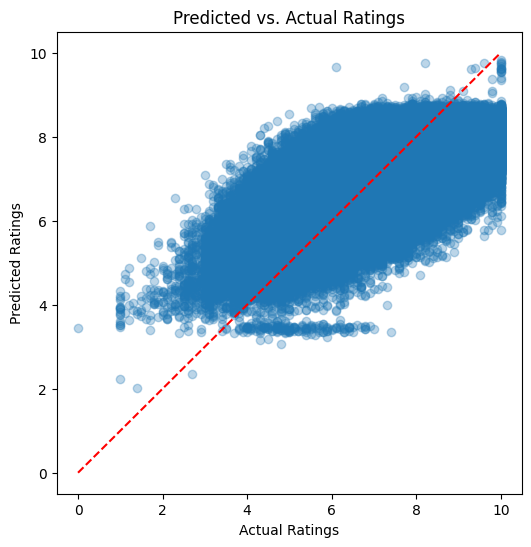

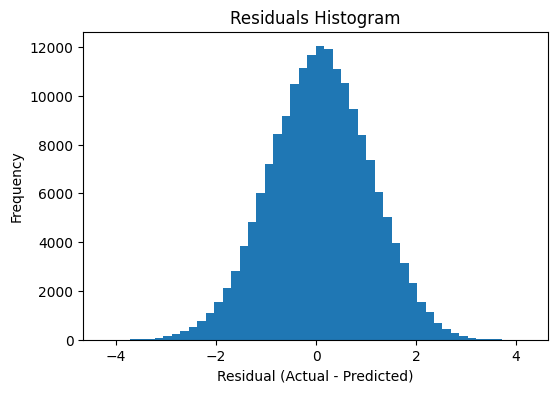

In [23]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load model
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Collect predictions and truths
all_preds = []
all_truths = []

with torch.no_grad():
    for user, movie, num_feats, emb_idx, rating in test_loader:
        user = user.to(device)
        movie = movie.to(device)
        num_feats = num_feats.to(device)
        emb_idx = emb_idx.to(device)
        rating = rating.to(device)

        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)
        watch_history_ids = torch.zeros((user.size(0), 10), dtype=torch.long).to(device)

        preds = model(user, movie, watch_history_ids, num_feats, text_embeds)
        all_preds.extend(preds.cpu().numpy())
        all_truths.extend(rating.cpu().numpy())

all_preds = np.array(all_preds)
all_truths = np.array(all_truths)

# Denormalize if needed (we scaled ratings to 0-1)
all_preds = all_preds * 10
all_truths = all_truths * 10

# Metrics
rmse = np.sqrt(mean_squared_error(all_truths, all_preds))
mae = mean_absolute_error(all_truths, all_preds)
r2 = r2_score(all_truths, all_preds)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(all_truths, all_preds, alpha=0.3)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs. Actual Ratings')
plt.plot([0, 10], [0, 10], '--', color='red')
plt.show()

# Residuals histogram
residuals = all_truths - all_preds
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerRecSys(num_users, num_movies, num_num_features, embedding_dim=128, text_embedding_dim=emb_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss_fn = nn.MSELoss()
margin_loss_fn = nn.MarginRankingLoss(margin=1.0)

best_val_loss = float('inf')
patience = 5
patience_counter = 0
epochs = 20

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    rank_loss_accum = 0
    mse_loss_accum = 0

    for user, movie, num_feats, emb_idx, rating in train_loader:
        user = user.to(device)
        movie = movie.to(device)
        num_feats = num_feats.to(device)
        emb_idx = emb_idx.to(device)
        rating = rating.to(device)

        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)
        watch_history_ids = torch.zeros((user.size(0), 10), dtype=torch.long).to(device)

        optimizer.zero_grad()
        preds = model(user, movie, watch_history_ids, num_feats, text_embeds)
        mse_loss = mse_loss_fn(preds, rating)

        # Build ranking pairs: positive (high rating) vs negative (low rating)
        pos_mask = rating > 7
        neg_mask = rating < 4
        pos_preds = preds[pos_mask]
        neg_preds = preds[neg_mask]

        if len(pos_preds) > 0 and len(neg_preds) > 0:
            min_len = min(len(pos_preds), len(neg_preds))
            pos_sample = pos_preds[:min_len]
            neg_sample = neg_preds[:min_len]
            rank_loss = margin_loss_fn(pos_sample, neg_sample, torch.ones_like(pos_sample))
        else:
            rank_loss = torch.tensor(0.0, device=device)

        total_loss = mse_loss + 0.5 * rank_loss
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item() * user.size(0)
        mse_loss_accum += mse_loss.item() * user.size(0)
        rank_loss_accum += rank_loss.item() * user.size(0)

    train_loss /= train_size
    mse_loss_accum /= train_size
    rank_loss_accum /= train_size

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for user, movie, num_feats, emb_idx, rating in val_loader:
            user = user.to(device)
            movie = movie.to(device)
            num_feats = num_feats.to(device)
            emb_idx = emb_idx.to(device)
            rating = rating.to(device)

            text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)
            watch_history_ids = torch.zeros((user.size(0), 10), dtype=torch.long).to(device)

            preds = model(user, movie, watch_history_ids, num_feats, text_embeds)
            loss = mse_loss_fn(preds, rating)
            val_loss += loss.item() * user.size(0)
    val_loss /= val_size

    print(f"Epoch {epoch}: Train Loss {train_loss:.4f} (MSE {mse_loss_accum:.4f}, Rank {rank_loss_accum:.4f}), Val Loss {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print("Saved new best model")
    else:
        patience_counter += 1
        print(f" No improvement, patience counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

print(f"Training complete! Best val loss: {best_val_loss:.4f}")

Epoch 1: Train Loss 0.0126 (MSE 0.0126, Rank 0.0000), Val Loss 0.0109
Saved new best model
Epoch 2: Train Loss 0.0108 (MSE 0.0108, Rank 0.0000), Val Loss 0.0102
Saved new best model
Epoch 3: Train Loss 0.0105 (MSE 0.0105, Rank 0.0000), Val Loss 0.0102
 No improvement, patience counter: 1/5
Epoch 4: Train Loss 0.0104 (MSE 0.0104, Rank 0.0000), Val Loss 0.0102
 No improvement, patience counter: 2/5
Epoch 5: Train Loss 0.0102 (MSE 0.0102, Rank 0.0000), Val Loss 0.0103
 No improvement, patience counter: 3/5
Epoch 6: Train Loss 0.0101 (MSE 0.0101, Rank 0.0000), Val Loss 0.0104
 No improvement, patience counter: 4/5
Epoch 7: Train Loss 0.0098 (MSE 0.0098, Rank 0.0000), Val Loss 0.0104
 No improvement, patience counter: 5/5
Early stopping triggered
Training complete! Best val loss: 0.0102


In [27]:
import torch.nn.functional as F
# Load best model
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

test_loss = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for user, movie, num_feats, emb_idx, rating in test_loader:
        user = user.to(device)
        movie = movie.to(device)
        num_feats = num_feats.to(device)
        emb_idx = emb_idx.to(device)
        rating = rating.to(device)

        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)
        watch_history_ids = torch.zeros((user.size(0), 10), dtype=torch.long).to(device)

        preds = model(user, movie, watch_history_ids, num_feats, text_embeds)
        test_loss += mse_loss_fn(preds, rating).item() * user.size(0)

        all_preds.append(preds.cpu())
        all_targets.append(rating.cpu())

test_loss /= len(test_loader.dataset)
all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

# Compute RMSE, MAE, R²
rmse = torch.sqrt(F.mse_loss(all_preds, all_targets)).item()
mae = F.l1_loss(all_preds, all_targets).item()
ss_res = torch.sum((all_targets - all_preds) ** 2)
ss_tot = torch.sum((all_targets - all_targets.mean()) ** 2)
r2 = 1 - ss_res / ss_tot

print(f"Final Test MSE Loss: {test_loss:.4f}")
print(f"Final Test RMSE: {rmse:.4f}")
print(f"Final Test MAE: {mae:.4f}")
print(f"Final Test R²: {r2:.4f}")

Final Test MSE Loss: 0.0102
Final Test RMSE: 0.1009
Final Test MAE: 0.0807
Final Test R²: 0.4097


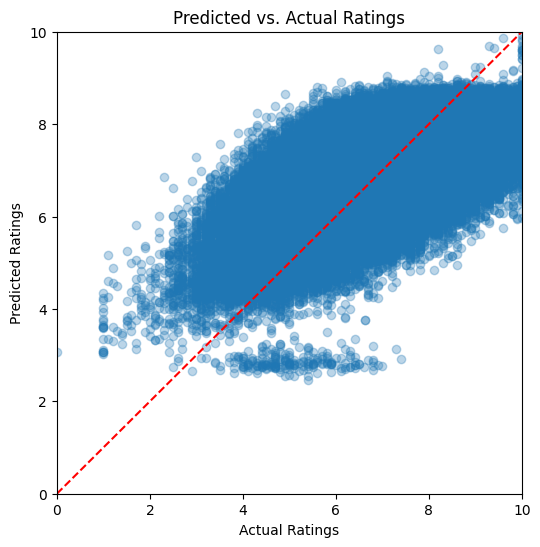

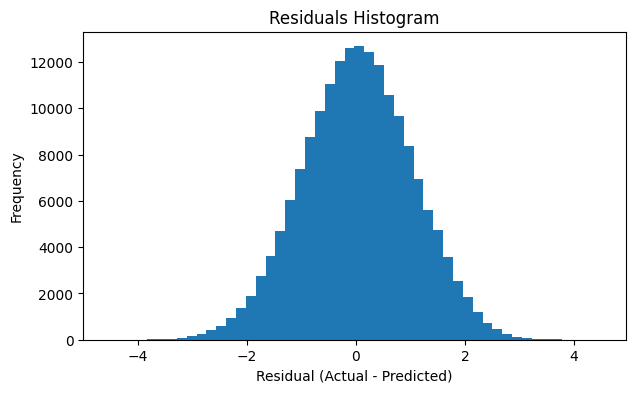

In [28]:
import matplotlib.pyplot as plt

# Convert to numpy arrays
actual = all_targets.numpy() * 10  # un-normalize back to 0–10
predicted = all_preds.numpy() * 10

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(6, 6))
plt.scatter(actual, predicted, alpha=0.3)
plt.plot([0, 10], [0, 10], 'r--')  # perfect prediction line
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs. Actual Ratings')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

# Residuals histogram
residuals = actual - predicted
plt.figure(figsize=(7, 4))
plt.hist(residuals, bins=50)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

In [42]:
def recommend_for_user(user_id, N=10):
    user_idx = data['user2idx'].get(user_id)
    if user_idx is None:
        print(f"User {user_id} not found.")
        return

    seen_movie_idxs = set(X_movie[X_user == user_idx].tolist())
    all_movie_idxs = set(range(num_movies))
    unseen_movie_idxs = list(all_movie_idxs - seen_movie_idxs)

    user_tensor = torch.tensor([user_idx] * len(unseen_movie_idxs)).to(device)
    movie_tensor = torch.tensor(unseen_movie_idxs).to(device)
    num_feats = X_num[:len(unseen_movie_idxs)].to(device)
    emb_idx = torch.tensor(unseen_movie_idxs).to(device)
    watch_history_ids = torch.zeros((len(unseen_movie_idxs), 10), dtype=torch.long).to(device)
    text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

    with torch.no_grad():
        preds = model(user_tensor, movie_tensor, watch_history_ids, num_feats, text_embeds).cpu().numpy()

    top_indices = preds.argsort()[-N:][::-1]
    top_movie_idxs = [unseen_movie_idxs[i] for i in top_indices]

    # NEW: idx2movie
    idx2movie = {v: k for k, v in data['movie2idx'].items()}
    top_movie_ids = [idx2movie[idx] for idx in top_movie_idxs]

    print(f"\nTop {N} recommendations for user {user_id}:")
    for i, movie_id in enumerate(top_movie_ids):
        print(f"{i+1}. Movie ID: {movie_id} → Predicted score: {preds[top_indices[i]]:.2f}")

In [43]:
recommend_for_user('90', N=5)


Top 5 recommendations for user 90:
1. Movie ID: 16023 → Predicted score: 0.89
2. Movie ID: 23571 → Predicted score: 0.89
3. Movie ID: 17204 → Predicted score: 0.89
4. Movie ID: 22724 → Predicted score: 0.89
5. Movie ID: 20899 → Predicted score: 0.89


In [31]:
print(list(data['user2idx'].keys())[:10])  # show first 10 mapped user IDs

['90', '574', '1894', '3882', '4360', '4652', '2203', '5106', '5652', '5588']


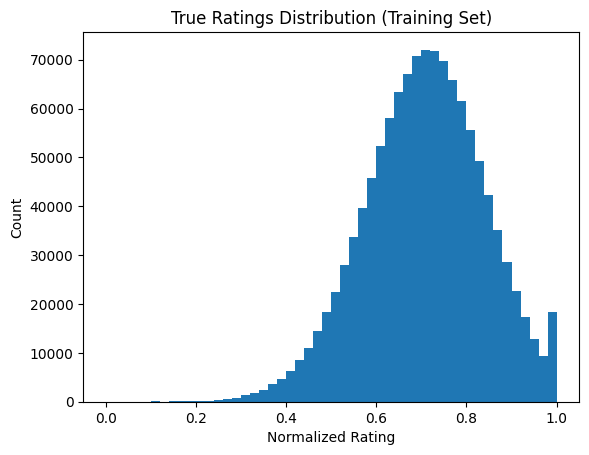

In [44]:
plt.hist(y_rating.cpu().numpy(), bins=50)
plt.title("True Ratings Distribution (Training Set)")
plt.xlabel("Normalized Rating")
plt.ylabel("Count")
plt.show()

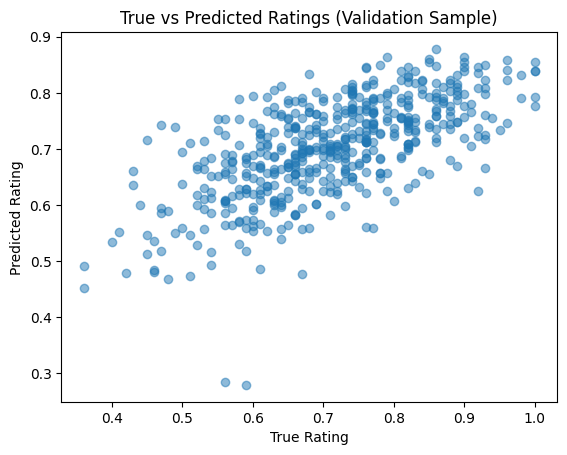

In [45]:
model.eval()
with torch.no_grad():
    user, movie, num_feats, emb_idx, rating = next(iter(val_loader))
    user, movie, num_feats, emb_idx, rating = user.to(device), movie.to(device), num_feats.to(device), emb_idx.to(device), rating.to(device)
    text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)
    watch_history_ids = torch.zeros((user.size(0), 10), dtype=torch.long).to(device)

    preds = model(user, movie, watch_history_ids, num_feats, text_embeds).cpu().numpy()
    true_ratings = rating.cpu().numpy()

plt.scatter(true_ratings, preds, alpha=0.5)
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")
plt.title("True vs Predicted Ratings (Validation Sample)")
plt.show()

In [6]:
mask = ~torch.isnan(y_rating)
X_user = X_user[mask]
X_movie = X_movie[mask]
X_num = X_num[mask]
X_emb_idx = X_emb_idx[mask]
y_rating = y_rating[mask]

print(f"Cleaned NaNs, new dataset size: {len(y_rating)}")

# === SPLIT DATA ===
dataset = TensorDataset(X_user, X_movie, X_num, X_emb_idx, y_rating)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512)
test_loader = DataLoader(test_dataset, batch_size=512)

print(f"Split: {train_size} train, {val_size} val, {test_size} test")


Cleaned NaNs, new dataset size: 1188534
Split: 831973 train, 178280 val, 178281 test


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerRecSys(num_users, num_movies, num_num_features, embedding_dim=128, text_embedding_dim=emb_dim)
model.load_state_dict(torch.load('best_model.pt'))
model.to(device)
model.eval()
print("Loaded best_model.pt and ready for inference!")

Loaded best_model.pt and ready for inference!


In [3]:
import torch
import numpy as np

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the .pt data package
data = torch.load('final_training_data_with_watch.pt', map_location=device)
print(f"Loaded keys: {list(data.keys())}")

# Unpack
X_user = data['X_user']
X_movie = data['X_movie']
X_num = data['X_num']
X_emb_idx = data['X_emb_idx']
X_emb_matrix = data['X_emb_matrix']
watch_history = data['watch_history']
y_rating = data['y_rating']

num_users = data['num_users']
num_movies = data['num_movies']
num_features = X_num.shape[1]
embedding_dim = X_emb_matrix.shape[1]

print(f"Users: {num_users}, Movies: {num_movies}, Features: {num_features}, Embedding dim: {embedding_dim}")

mask = ~torch.isnan(y_rating)
X_user = X_user[mask]
X_movie = X_movie[mask]
X_num = X_num[mask]
X_emb_idx = X_emb_idx[mask]
y_rating = y_rating[mask]

print(f"After cleaning: {len(y_rating)} rows")

Using device: cuda
Loaded keys: ['X_user', 'X_movie', 'X_num', 'X_emb_idx', 'X_emb_matrix', 'watch_history', 'y_rating', 'user2idx', 'movie2idx', 'num_features', 'num_users', 'num_movies']
Users: 10007, Movies: 26189, Features: 5, Embedding dim: 384
After cleaning: 1200851 rows


In [4]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Create dataset
dataset = TensorDataset(X_user, X_movie, X_num, X_emb_idx, watch_history[X_user], y_rating)

# Split sizes
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split datasets
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
batch_size = 512
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

print(f"Data split: {train_size} train / {val_size} val / {test_size} test")

Data split: 960680 train / 120085 val / 120086 test


In [4]:
import torch.nn as nn

class TransformerRecSys(nn.Module):
    def __init__(self, num_users, num_movies, num_numeric, embedding_dim=128, nhead=4, num_layers=2, dropout=0.1, seq_len=10, text_embedding_dim=384):
        super().__init__()

        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.position_embedding = nn.Embedding(seq_len, embedding_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.numeric_fc = nn.Linear(num_numeric, embedding_dim)
        self.text_fc = nn.Linear(text_embedding_dim, embedding_dim)

        self.output_fc = nn.Sequential(
            nn.Linear(embedding_dim * 4, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )

    def forward(self, user_ids, target_movie_ids, watch_history_ids, numeric_feats, text_embeds):
        batch_size, seq_len = watch_history_ids.shape

        user_emb = self.user_embedding(user_ids)
        movie_emb = self.movie_embedding(target_movie_ids)

        history_emb = self.movie_embedding(watch_history_ids)
        pos_ids = torch.arange(seq_len, device=watch_history_ids.device).unsqueeze(0).expand(batch_size, seq_len)
        pos_emb = self.position_embedding(pos_ids)
        history_with_pos = history_emb + pos_emb

        transformed = self.transformer(history_with_pos)
        pooled_history = transformed.mean(dim=1)

        numeric_proj = self.numeric_fc(numeric_feats)
        text_proj = self.text_fc(text_embeds)

        combined = torch.cat([user_emb, movie_emb, pooled_history, numeric_proj + text_proj], dim=1)
        output = self.output_fc(combined).squeeze(1)
        return output

model = TransformerRecSys(num_users, num_movies, num_features, embedding_dim=128, text_embedding_dim=embedding_dim).to(device)
print("Model initialized")

Model initialized


In [17]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# === Prepare dataset ===
per_sample_watch = watch_history[X_user]

dataset = TensorDataset(X_user, X_movie, X_num, X_emb_idx, per_sample_watch, y_rating)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
val_loader = DataLoader(val_set, batch_size=512)
test_loader = DataLoader(test_set, batch_size=512)

# === Setup model, optimizer, loss ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerRecSys(
    num_users=num_users,
    num_movies=num_movies,
    num_numeric=X_num.shape[1],
    embedding_dim=128,
    text_embedding_dim=X_emb_matrix.shape[1]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

# === Early stopping ===
best_val_loss = float('inf')
patience = 5
patience_counter = 0
epochs = 20

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for user, movie, num_feats, emb_idx, watch_hist, rating in train_loader:
        user, movie, num_feats, emb_idx, watch_hist, rating = \
            user.to(device), movie.to(device), num_feats.to(device), emb_idx.to(device), watch_hist.to(device), rating.to(device)

        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

        optimizer.zero_grad()
        preds = model(user, movie, watch_hist, num_feats, text_embeds)
        loss = loss_fn(preds, rating)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * user.size(0)

    train_loss /= train_size

    # === Validation ===
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for user, movie, num_feats, emb_idx, watch_hist, rating in val_loader:
            user, movie, num_feats, emb_idx, watch_hist, rating = \
                user.to(device), movie.to(device), num_feats.to(device), emb_idx.to(device), watch_hist.to(device), rating.to(device)

            text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)
            preds = model(user, movie, watch_hist, num_feats, text_embeds)
            loss = loss_fn(preds, rating)
            val_loss += loss.item() * user.size(0)

    val_loss /= val_size
    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print("Saved new best model")
    else:
        patience_counter += 1
        print(f"Patience {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

print(f"Training complete! Best val loss: {best_val_loss:.4f}")

# === Final test evaluation ===
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

test_loss = 0
all_preds = []
all_truth = []

with torch.no_grad():
    for user, movie, num_feats, emb_idx, watch_hist, rating in test_loader:
        user, movie, num_feats, emb_idx, watch_hist, rating = \
            user.to(device), movie.to(device), num_feats.to(device), emb_idx.to(device), watch_hist.to(device), rating.to(device)

        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)
        preds = model(user, movie, watch_hist, num_feats, text_embeds)
        all_preds.append(preds.cpu())
        all_truth.append(rating.cpu())

        test_loss += loss_fn(preds, rating).item() * user.size(0)

test_loss /= test_size

all_preds = torch.cat(all_preds).numpy()
all_truth = torch.cat(all_truth).numpy()

rmse = np.sqrt(test_loss)
mae = np.mean(np.abs(all_preds - all_truth))
r2 = 1 - np.sum((all_truth - all_preds)**2) / np.sum((all_truth - np.mean(all_truth))**2)

print(f"\nFinal Test MSE Loss: {test_loss:.4f}")
print(f"Final Test RMSE: {rmse:.4f}")
print(f"Final Test MAE: {mae:.4f}")
print(f"Final Test R²: {r2:.4f}")

Epoch 1: Train Loss 1.2514, Val Loss 1.0395
Saved new best model
Epoch 2: Train Loss 1.0722, Val Loss 1.0577
Patience 1/5
Epoch 3: Train Loss 1.0618, Val Loss 1.0158
Saved new best model
Epoch 4: Train Loss 1.0496, Val Loss 1.0121
Saved new best model
Epoch 5: Train Loss 1.0394, Val Loss 1.0171
Patience 1/5
Epoch 6: Train Loss 1.0290, Val Loss 1.1099
Patience 2/5
Epoch 7: Train Loss 1.0173, Val Loss 1.0292
Patience 3/5
Epoch 8: Train Loss 1.0049, Val Loss 1.0310
Patience 4/5
Epoch 9: Train Loss 0.9913, Val Loss 1.0436
Patience 5/5
Early stopping triggered
Training complete! Best val loss: 1.0121

Final Test MSE Loss: 1.0044
Final Test RMSE: 1.0022
Final Test MAE: 0.8024
Final Test R²: 0.4167


In [21]:

y_test = []
test_preds = []

model.eval()
with torch.no_grad():
    for user, movie, num_feats, emb_idx, watch_hist, rating in test_loader:
        user = user.to(device)
        movie = movie.to(device)
        num_feats = num_feats.to(device)
        emb_idx = emb_idx.to(device)
        watch_hist = watch_hist.to(device)
        rating = rating.to(device)

        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)
        preds = model(user, movie, watch_hist, num_feats, text_embeds)

        y_test.append(rating.cpu())
        test_preds.append(preds.cpu())

# Concatenate all batches
y_test = torch.cat(y_test)
test_preds = torch.cat(test_preds)

print("Collected predictions on test set")

Collected predictions on test set


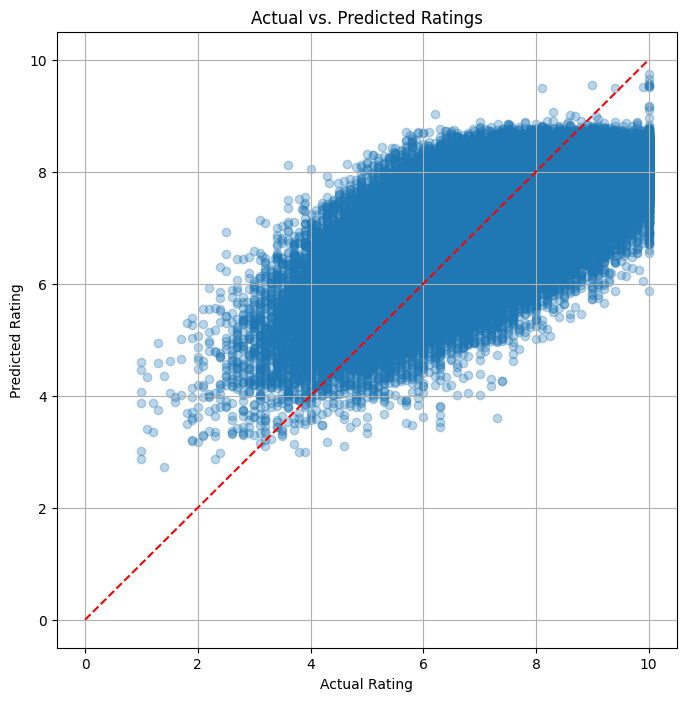

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(y_test.numpy(), test_preds.numpy(), alpha=0.3)
plt.plot([0, 10], [0, 10], color='red', linestyle='--')  # perfect line
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs. Predicted Ratings')
plt.grid(True)
plt.show()

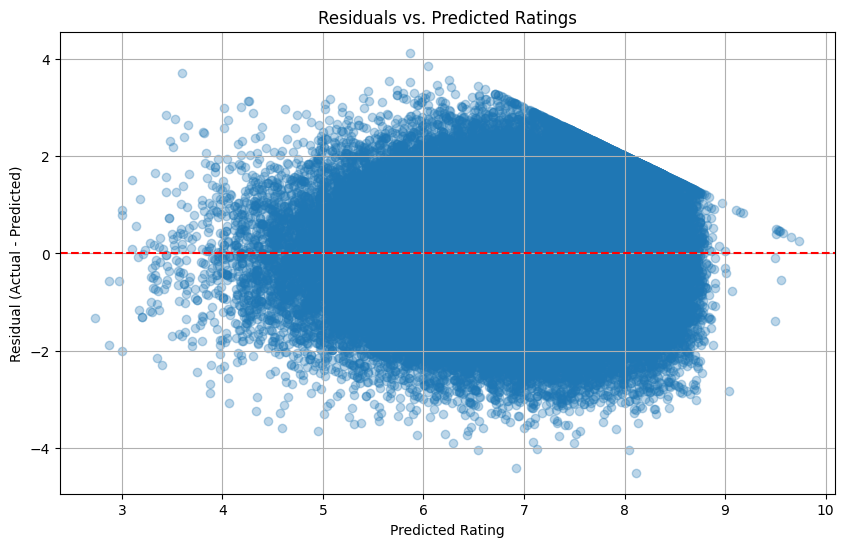

In [23]:
residuals = y_test.numpy() - test_preds.numpy()

plt.figure(figsize=(10, 6))
plt.scatter(test_preds.numpy(), residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Rating')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs. Predicted Ratings')
plt.grid(True)
plt.show()

In [24]:
class TransformerRecSys(nn.Module):
    def __init__(self, num_users, num_movies, num_numeric, embedding_dim=256, nhead=8, num_layers=4, dropout=0.3, seq_len=10, text_embedding_dim=384):
        super().__init__()

        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.position_embedding = nn.Embedding(seq_len, embedding_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.numeric_fc = nn.Linear(num_numeric, embedding_dim)
        self.text_fc = nn.Linear(text_embedding_dim, embedding_dim)

        self.output_fc = nn.Sequential(
            nn.Linear(embedding_dim * 4, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, user_ids, target_movie_ids, watch_history_ids, numeric_feats, text_embeds):
        batch_size, seq_len = watch_history_ids.shape

        user_emb = self.user_embedding(user_ids)
        movie_emb = self.movie_embedding(target_movie_ids)

        history_emb = self.movie_embedding(watch_history_ids)
        pos_ids = torch.arange(seq_len, device=watch_history_ids.device).unsqueeze(0).expand(batch_size, seq_len)
        pos_emb = self.position_embedding(pos_ids)
        history_with_pos = history_emb + pos_emb

        transformed = self.transformer(history_with_pos)
        pooled_history = transformed.mean(dim=1)

        numeric_proj = self.numeric_fc(numeric_feats)
        text_proj = self.text_fc(text_embeds)

        combined = torch.cat([user_emb, movie_emb, pooled_history, numeric_proj + text_proj], dim=1)
        output = self.output_fc(combined).squeeze(1)

        return output

In [25]:
import torch.nn.utils
from torch.optim.lr_scheduler import ReduceLROnPlateau

epochs = 100
patience = 10
clip_value = 1.0
batch_size = 256

model = TransformerRecSys(num_users, num_movies, num_num_features, embedding_dim=256, nhead=8, num_layers=4, dropout=0.3, text_embedding_dim=emb_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
loss_fn = nn.MSELoss()

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for user, movie, num_feats, emb_idx, watch, rating in train_loader:
        user, movie, num_feats, emb_idx, watch, rating = user.to(device), movie.to(device), num_feats.to(device), emb_idx.to(device), watch.to(device), rating.to(device)
        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

        optimizer.zero_grad()
        preds = model(user, movie, watch, num_feats, text_embeds)
        loss = loss_fn(preds, rating)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        train_loss += loss.item() * user.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    with torch.no_grad():
        for user, movie, num_feats, emb_idx, watch, rating in val_loader:
            user, movie, num_feats, emb_idx, watch, rating = user.to(device), movie.to(device), num_feats.to(device), emb_idx.to(device), watch.to(device), rating.to(device)
            text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)
            preds = model(user, movie, watch, num_feats, text_embeds)
            loss = loss_fn(preds, rating)
            val_loss += loss.item() * user.size(0)
            val_preds.append(preds.cpu())
            val_targets.append(rating.cpu())
    val_loss /= len(val_loader.dataset)
    scheduler.step(val_loss)

    val_preds = torch.cat(val_preds)
    val_targets = torch.cat(val_targets)
    val_rmse = torch.sqrt(nn.MSELoss()(val_preds, val_targets))
    val_mae = nn.L1Loss()(val_preds, val_targets)

    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, Val RMSE {val_rmse:.4f}, Val MAE {val_mae:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print(" Saved new best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

print(f"Training complete! Best val loss: {best_val_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss 1.9225, Val Loss 1.0273, Val RMSE 1.0135, Val MAE 0.8103
 Saved new best model
Epoch 2: Train Loss 1.4026, Val Loss 1.0388, Val RMSE 1.0192, Val MAE 0.8154
Epoch 3: Train Loss 1.3809, Val Loss 1.0144, Val RMSE 1.0072, Val MAE 0.8062
 Saved new best model
Epoch 4: Train Loss 1.3564, Val Loss 1.0351, Val RMSE 1.0174, Val MAE 0.8146
Epoch 5: Train Loss 1.3394, Val Loss 1.0011, Val RMSE 1.0006, Val MAE 0.8021
 Saved new best model
Epoch 6: Train Loss 1.3230, Val Loss 1.0002, Val RMSE 1.0001, Val MAE 0.8019
 Saved new best model
Epoch 7: Train Loss 1.3051, Val Loss 1.0051, Val RMSE 1.0026, Val MAE 0.8033
Epoch 8: Train Loss 1.2896, Val Loss 1.0054, Val RMSE 1.0027, Val MAE 0.8036
Epoch 9: Train Loss 1.2757, Val Loss 0.9997, Val RMSE 0.9999, Val MAE 0.8014
 Saved new best model
Epoch 10: Train Loss 1.2637, Val Loss 1.0091, Val RMSE 1.0045, Val MAE 0.8046
Epoch 11: Train Loss 1.2486, Val Loss 1.0001, Val RMSE 1.0000, Val MAE 0.8018
Epoch 12: Train Loss 1.2363, Val Loss 1.0

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load best model
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Run on test set
all_preds = []
all_targets = []

with torch.no_grad():
    for user, movie, num_feats, emb_idx, watch_hist, rating in test_loader:
        user = user.to(device)
        movie = movie.to(device)
        num_feats = num_feats.to(device)
        emb_idx = emb_idx.to(device)
        watch_hist = watch_hist.to(device)
        rating = rating.to(device)

        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)
        preds = model(user, movie, watch_hist, num_feats, text_embeds)
        all_preds.append(preds.cpu())
        all_targets.append(rating.cpu())

# Combine predictions and targets
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

# Compute metrics
mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print(f"\nFinal Test MSE: {mse:.4f}")
print(f"Final Test RMSE: {rmse:.4f}")
print(f" Final Test MAE: {mae:.4f}")
print(f"Final Test R²: {r2:.4f}")


Final Test MSE: 0.9899
Final Test RMSE: 0.9949
 Final Test MAE: 0.7964
Final Test R²: 0.4251


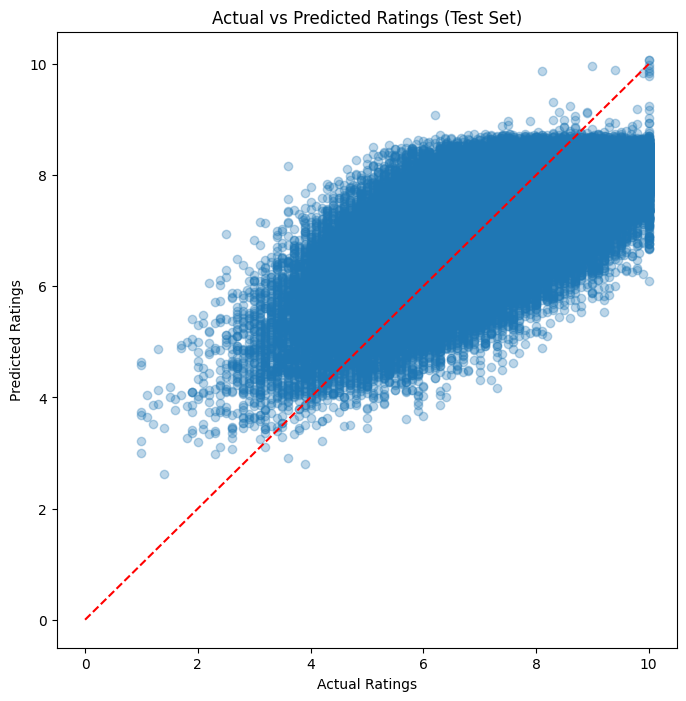

In [27]:
plt.figure(figsize=(8, 8))
plt.scatter(all_targets, all_preds, alpha=0.3)
plt.plot([0, 10], [0, 10], color='red', linestyle='--')  # perfect prediction line
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings (Test Set)')
plt.show()

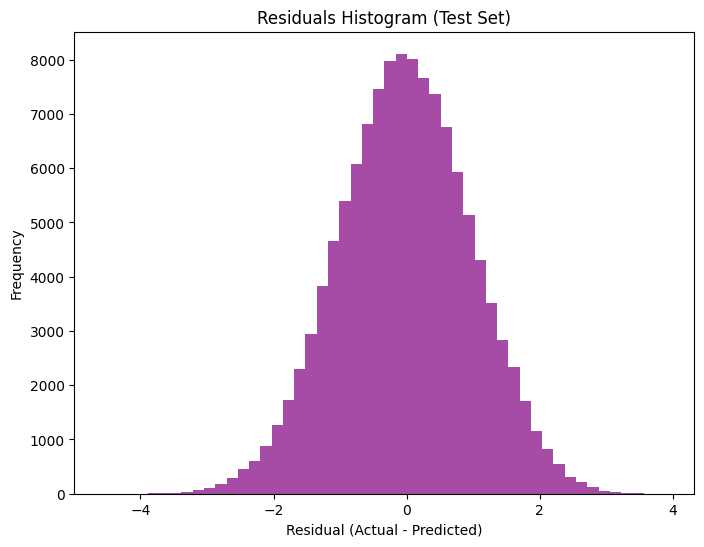

In [28]:
residuals = all_targets - all_preds

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, color='purple', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residuals Histogram (Test Set)')
plt.show()

In [29]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.5 MB/s eta 0:00:00


In [32]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def objective(trial):
    embedding_dim = trial.suggest_categorical('embedding_dim', [64, 128, 256])
    num_heads = trial.suggest_categorical('num_heads', [2, 4, 8])
    num_layers = trial.suggest_int('num_layers', 1, 4)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [256, 512, 1024])

    # Prepare dataset
    row_watch_history = watch_history[X_user]
    dataset = TensorDataset(X_user, X_movie, X_num, X_emb_idx, row_watch_history, y_rating)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    model = TransformerRecSys(num_users, num_movies, X_num.shape[1], embedding_dim=embedding_dim,
                              nhead=num_heads, num_layers=num_layers, dropout=dropout,
                              text_embedding_dim=X_emb_matrix.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val_rmse = float('inf')
    patience = 3
    patience_counter = 0

    for epoch in range(10):  # Shorter loop for tuning
        model.train()
        for user, movie, num_feats, emb_idx, hist, rating in train_loader:
            user, movie, num_feats, emb_idx, hist, rating = user.to(device), movie.to(device), num_feats.to(device), emb_idx.to(device), hist.to(device), rating.to(device)
            text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

            optimizer.zero_grad()
            preds = model(user, movie, hist, num_feats, text_embeds)
            loss = loss_fn(preds, rating)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for user, movie, num_feats, emb_idx, hist, rating in val_loader:
                user, movie, num_feats, emb_idx, hist, rating = user.to(device), movie.to(device), num_feats.to(device), emb_idx.to(device), hist.to(device), rating.to(device)
                text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)
                preds = model(user, movie, hist, num_feats, text_embeds)
                val_loss += nn.functional.mse_loss(preds, rating, reduction='sum').item()
        val_loss /= val_size
        val_rmse = val_loss ** 0.5

        trial.report(val_rmse, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_val_rmse

In [33]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"  RMSE: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-01 22:53:45,440] A new study created in memory with name: no-name-b1665eb9-e687-468f-afdc-414687b71717
<ipython-input-32-690254d53664>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
[I 2025-06-01 22:59:48,942] Trial 0 finished with value: 1.0062916038619918 and parameters: {'embedding_dim': 128, 'num_heads': 4, 'num_layers': 3, 'dropout': 0.23407289985833565, 'lr': 0.0007459809612798395, 'batch_size': 512}. Best is trial 0 with value: 1.0062916038619918.
[I 2025-06-01 23:06:51,711] Trial 1 finished with value: 1.0055532628420032 and parameters: {'embedding_dim': 256, 'num_heads': 8, 'num_layers': 1, 'dropout': 0.39150650367223994, 'lr': 0.0003401949983631039, 'batch_size': 512}. Best is trial 1 with value: 1.0055532628420032.
[I 2025-06-01 23:13:49,958] Trial 2 finis

Best trial:
  RMSE: 1.0014186925964026
  Params:
    embedding_dim: 64
    num_heads: 4
    num_layers: 3
    dropout: 0.26167516793660744
    lr: 0.0006385196886505691
    batch_size: 256


In [12]:
import torch
import torch.nn as nn

class HybridTransformerMF(nn.Module):
    def __init__(self,
                 num_users,
                 num_movies,
                 num_numeric,
                 transformer_embedding_dim=64,
                 mf_embedding_dim=32,
                 num_heads=4,
                 num_layers=3,
                 dropout=0.26,
                 seq_len=10,
                 text_embedding_dim=384):
        super().__init__()

        # Transformer Block
        self.user_embedding = nn.Embedding(num_users, transformer_embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, transformer_embedding_dim)
        self.position_embedding = nn.Embedding(seq_len, transformer_embedding_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_embedding_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.numeric_fc = nn.Linear(num_numeric, transformer_embedding_dim)
        self.text_fc = nn.Linear(text_embedding_dim, transformer_embedding_dim)

        # Matrix Factorization Block
        self.mf_user_embedding = nn.Embedding(num_users, mf_embedding_dim)
        self.mf_movie_embedding = nn.Embedding(num_movies, mf_embedding_dim)

        # Final Combiner
        combined_dim = transformer_embedding_dim * 4 + 1  # transformer parts + mf score

        self.output_fc = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )

    def forward(self, user_ids, movie_ids, watch_history_ids, numeric_feats, text_embeds):
        batch_size, seq_len = watch_history_ids.shape

        # Transformer block
        user_emb = self.user_embedding(user_ids)
        movie_emb = self.movie_embedding(movie_ids)
        history_emb = self.movie_embedding(watch_history_ids)

        pos_ids = torch.arange(seq_len, device=watch_history_ids.device).unsqueeze(0).expand(batch_size, seq_len)
        pos_emb = self.position_embedding(pos_ids)

        history_with_pos = history_emb + pos_emb
        transformed = self.transformer(history_with_pos)
        pooled_history = transformed.mean(dim=1)

        numeric_proj = self.numeric_fc(numeric_feats)
        text_proj = self.text_fc(text_embeds)

        transformer_output = torch.cat([user_emb, movie_emb, pooled_history, numeric_proj + text_proj], dim=1)

        # MF block
        mf_user = self.mf_user_embedding(user_ids)
        mf_movie = self.mf_movie_embedding(movie_ids)
        mf_score = torch.sum(mf_user * mf_movie, dim=1, keepdim=True)  # (batch, 1)

        # Combine both
        combined = torch.cat([transformer_output, mf_score], dim=1)
        output = self.output_fc(combined).squeeze(1)

        return output

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Align watch history per row ===
aligned_watch_history = torch.zeros((len(X_user), watch_history.shape[1]), dtype=torch.long)
for idx, u_idx in enumerate(X_user):
    aligned_watch_history[idx] = watch_history[u_idx]

# === Prepare dataset ===
dataset = TensorDataset(X_user, X_movie, X_num, X_emb_idx, aligned_watch_history, y_rating)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)

# === Initialize model ===
model = HybridTransformerMF(num_users=num_users,
                            num_movies=num_movies,
                            num_numeric=X_num.shape[1],
                            transformer_embedding_dim=64,
                            mf_embedding_dim=32,
                            num_heads=4,
                            num_layers=3,
                            dropout=0.26,
                            seq_len=watch_history.shape[1],
                            text_embedding_dim=X_emb_matrix.shape[1]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

best_val_loss = float('inf')
patience = 5
patience_counter = 0
epochs = 30

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for user, movie, num_feats, emb_idx, watch_hist, rating in train_loader:
        user, movie = user.to(device), movie.to(device)
        num_feats, emb_idx, watch_hist = num_feats.to(device), emb_idx.to(device), watch_hist.to(device)
        rating = rating.to(device)

        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

        optimizer.zero_grad()
        preds = model(user, movie, watch_hist, num_feats, text_embeds)
        loss = loss_fn(preds, rating)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * user.size(0)
    train_loss /= train_size

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for user, movie, num_feats, emb_idx, watch_hist, rating in val_loader:
            user, movie = user.to(device), movie.to(device)
            num_feats, emb_idx, watch_hist = num_feats.to(device), emb_idx.to(device), watch_hist.to(device)
            rating = rating.to(device)

            text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

            preds = model(user, movie, watch_hist, num_feats, text_embeds)
            loss = loss_fn(preds, rating)
            val_loss += loss.item() * user.size(0)
    val_loss /= val_size

    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_hybrid_model.pt')
        print("Saved new best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

print(f"Training complete! Best val loss: {best_val_loss:.4f}")

Epoch 1: Train Loss 1.3134, Val Loss 1.0575
Saved new best model
Epoch 2: Train Loss 1.1422, Val Loss 1.0142
Saved new best model
Epoch 3: Train Loss 1.1148, Val Loss 1.0135
Saved new best model
Epoch 4: Train Loss 1.0934, Val Loss 1.0036
Saved new best model
Epoch 5: Train Loss 1.0706, Val Loss 1.0038
Epoch 6: Train Loss 1.0458, Val Loss 1.0226
Epoch 7: Train Loss 1.0128, Val Loss 1.0415
Epoch 8: Train Loss 0.9778, Val Loss 1.0730
Epoch 9: Train Loss 0.9385, Val Loss 1.0793
Early stopping triggered
Training complete! Best val loss: 1.0036


In [37]:
model.load_state_dict(torch.load('best_hybrid_model.pt'))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for user, movie, num_feats, emb_idx, watch_hist, rating in test_loader:
        user, movie = user.to(device), movie.to(device)
        num_feats, emb_idx, watch_hist = num_feats.to(device), emb_idx.to(device), watch_hist.to(device)
        rating = rating.to(device)

        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)
        preds = model(user, movie, watch_hist, num_feats, text_embeds)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(rating.cpu().numpy())

# Convert to arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Metrics
mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print(f"\nFinal Test MSE: {mse:.4f}")
print(f"Final Test RMSE: {rmse:.4f}")
print(f"Final Test MAE: {mae:.4f}")
print(f"Final Test R²: {r2:.4f}")


Final Test MSE: 1.0046
Final Test RMSE: 1.0023
Final Test MAE: 0.8017
Final Test R²: 0.4168


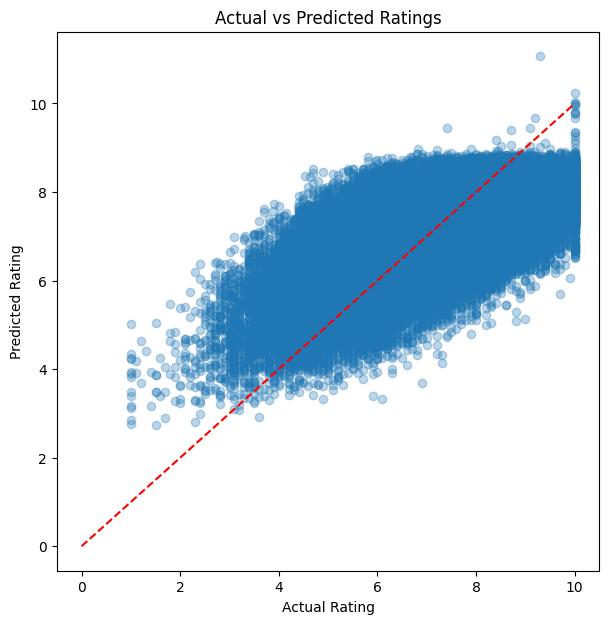

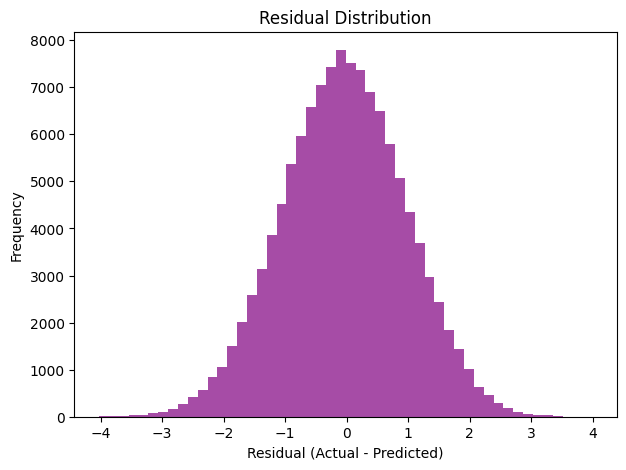

In [38]:
# Scatter plot: actual vs predicted
plt.figure(figsize=(7, 7))
plt.scatter(all_targets, all_preds, alpha=0.3)
plt.plot([0, 10], [0, 10], color='red', linestyle='--')  # perfect prediction line
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted Ratings')
plt.show()

# Residuals plot
residuals = all_targets - all_preds

plt.figure(figsize=(7, 5))
plt.hist(residuals, bins=50, color='purple', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.show()

In [39]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Align watch history per row ===
aligned_watch_history = torch.zeros((len(X_user), watch_history.shape[1]), dtype=torch.long)
for idx, u_idx in enumerate(X_user):
    aligned_watch_history[idx] = watch_history[u_idx]

# === Prepare dataset ===
dataset = TensorDataset(X_user, X_movie, X_num, X_emb_idx, aligned_watch_history, y_rating)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)

# === Initialize model ===
model = HybridTransformerMF(
    num_users=num_users,
    num_movies=num_movies,
    num_numeric=X_num.shape[1],
    transformer_embedding_dim=64,
    mf_embedding_dim=32,
    num_heads=4,
    num_layers=3,
    dropout=0.3,  # slightly increased dropout
    seq_len=watch_history.shape[1],
    text_embedding_dim=X_emb_matrix.shape[1]
).to(device)

# Optimizer with weight decay (regularization)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0006, weight_decay=1e-5)

# Loss: Huber loss (SmoothL1Loss)
loss_fn = nn.SmoothL1Loss()

# Learning rate scheduler (optional but recommended)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Training loop
best_val_loss = float('inf')
patience = 5
patience_counter = 0
epochs = 30

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for user, movie, num_feats, emb_idx, watch_hist, rating in train_loader:
        user, movie = user.to(device), movie.to(device)
        num_feats, emb_idx, watch_hist = num_feats.to(device), emb_idx.to(device), watch_hist.to(device)
        rating = rating.to(device)

        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

        optimizer.zero_grad()
        preds = model(user, movie, watch_hist, num_feats, text_embeds)
        loss = loss_fn(preds, rating)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * user.size(0)
    train_loss /= train_size

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for user, movie, num_feats, emb_idx, watch_hist, rating in val_loader:
            user, movie = user.to(device), movie.to(device)
            num_feats, emb_idx, watch_hist = num_feats.to(device), emb_idx.to(device), watch_hist.to(device)
            rating = rating.to(device)

            text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

            preds = model(user, movie, watch_hist, num_feats, text_embeds)
            loss = loss_fn(preds, rating)
            val_loss += loss.item() * user.size(0)
    val_loss /= val_size

    scheduler.step(val_loss)

    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_hybrid_huber_model.pt')
        print("Saved new best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(" Early stopping triggered")
            break

print(f" Training complete! Best val loss: {best_val_loss:.4f}")

Epoch 1: Train Loss 0.5207, Val Loss 0.4402
Saved new best model
Epoch 2: Train Loss 0.4756, Val Loss 0.4591
Epoch 3: Train Loss 0.4688, Val Loss 0.4325
Saved new best model
Epoch 4: Train Loss 0.4629, Val Loss 0.4279
Saved new best model
Epoch 5: Train Loss 0.4577, Val Loss 0.4362
Epoch 6: Train Loss 0.4527, Val Loss 0.4355
Epoch 7: Train Loss 0.4477, Val Loss 0.4303
Epoch 8: Train Loss 0.4394, Val Loss 0.4292
Epoch 9: Train Loss 0.4356, Val Loss 0.4310
 Early stopping triggered
 Training complete! Best val loss: 0.4279


Final Test MSE: 0.9982
Final Test RMSE: 0.9991
Final Test MAE: 0.7995
Final Test R²: 0.4251


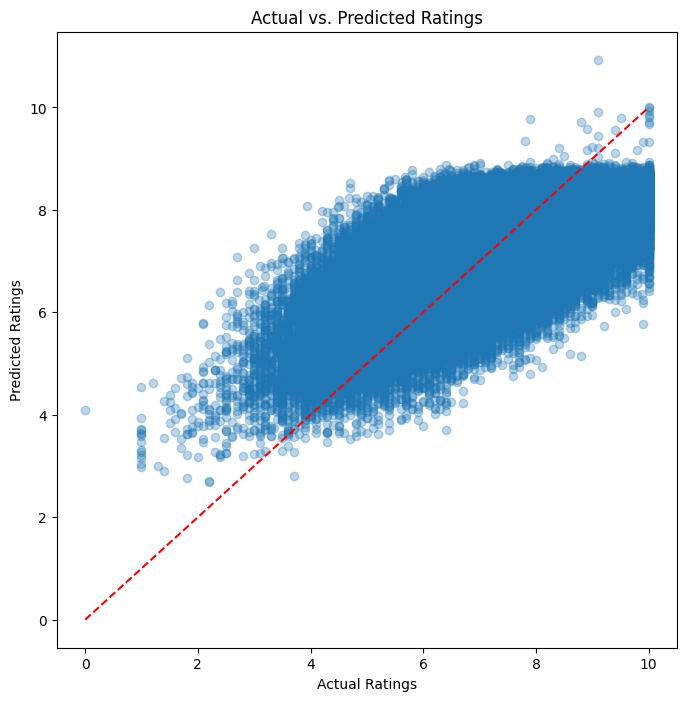

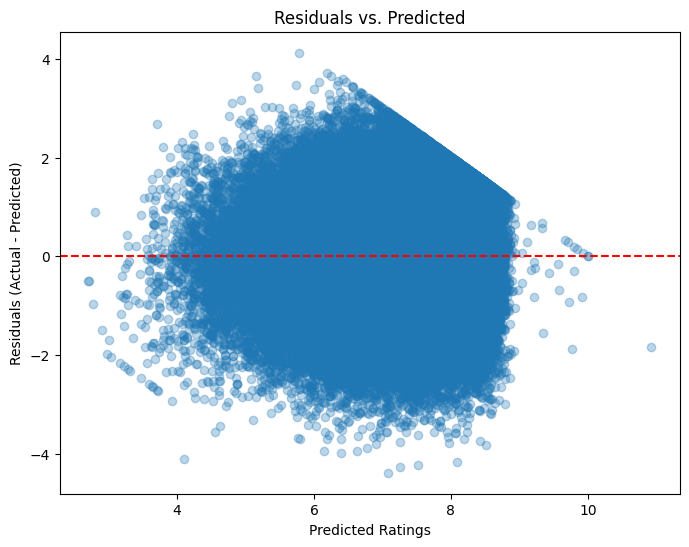

In [40]:
model.load_state_dict(torch.load('best_hybrid_model.pt'))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for user, movie, num_feats, emb_idx, watch_hist, rating in test_loader:
        user, movie = user.to(device), movie.to(device)
        num_feats, emb_idx, watch_hist = num_feats.to(device), emb_idx.to(device), watch_hist.to(device)
        rating = rating.to(device)

        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

        preds = model(user, movie, watch_hist, num_feats, text_embeds)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(rating.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print(f"Final Test MSE: {mse:.4f}")
print(f"Final Test RMSE: {rmse:.4f}")
print(f"Final Test MAE: {mae:.4f}")
print(f"Final Test R²: {r2:.4f}")

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(all_targets, all_preds, alpha=0.3)
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings')
plt.show()

# Residual plot
residuals = all_targets - all_preds
plt.figure(figsize=(8, 6))
plt.scatter(all_preds, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs. Predicted')
plt.show()

In [1]:
!pip install performer-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [13]:
from performer_pytorch import SelfAttention

class PerformerRecSys(nn.Module):
    def __init__(self, num_users, num_movies, num_numeric, embedding_dim=128,
                 num_heads=4, dropout=0.1, seq_len=10, text_embedding_dim=384):
        super().__init__()

        # embeddings
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.position_embedding = nn.Embedding(seq_len, embedding_dim)

        # performer attention layer (replaces transformer encoder)
        self.performer = SelfAttention(
            dim=embedding_dim,
            heads=num_heads,
            causal=False,
            dropout=dropout
        )

        # numeric + text feature projection
        self.numeric_fc = nn.Linear(num_numeric, embedding_dim)
        self.text_fc = nn.Linear(text_embedding_dim, embedding_dim)

        # output head
        self.output_fc = nn.Sequential(
            nn.Linear(embedding_dim * 4, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )

    def forward(self, user_ids, target_movie_ids, watch_history_ids, numeric_feats, text_embeds):
        batch_size, seq_len = watch_history_ids.shape

        user_emb = self.user_embedding(user_ids)  # (batch, embed)
        movie_emb = self.movie_embedding(target_movie_ids)  # (batch, embed)

        # watch history + positional embedding
        history_emb = self.movie_embedding(watch_history_ids)  # (batch, seq, embed)
        pos_ids = torch.arange(seq_len, device=watch_history_ids.device).unsqueeze(0).expand(batch_size, seq_len)
        pos_emb = self.position_embedding(pos_ids)
        history_input = history_emb + pos_emb

        # performer attention (per batch)
        transformed_history = self.performer(history_input)  # (batch, seq, embed)
        pooled_history = transformed_history.mean(dim=1)  # (batch, embed)

        numeric_proj = self.numeric_fc(numeric_feats)
        text_proj = self.text_fc(text_embeds)

        combined = torch.cat([user_emb, movie_emb, pooled_history, numeric_proj + text_proj], dim=1)
        output = self.output_fc(combined).squeeze(1)  # (batch,)

        return output

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256
epochs = 20
patience = 5

# === Prepare dataset ===
aligned_watch_history = torch.zeros((len(X_user), watch_history.shape[1]), dtype=torch.long)
for idx, u_idx in enumerate(X_user):
    aligned_watch_history[idx] = watch_history[u_idx]

dataset = TensorDataset(X_user, X_movie, X_num, X_emb_idx, aligned_watch_history, y_rating)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# === Initialize model ===
model = PerformerRecSys(
    num_users=num_users,
    num_movies=num_movies,
    num_numeric=X_num.shape[1],
    embedding_dim=64,
    num_heads=4,
    dropout=0.2,
    seq_len=watch_history.shape[1],
    text_embedding_dim=X_emb_matrix.shape[1]
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = nn.SmoothL1Loss()

best_val_loss = float('inf')
patience_counter = 0

# === Training Loop ===
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for user, movie, num_feats, emb_idx, watch_hist, rating in train_loader:
        user, movie = user.to(device), movie.to(device)
        num_feats, emb_idx, watch_hist = num_feats.to(device), emb_idx.to(device), watch_hist.to(device)
        rating = rating.to(device)
        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

        optimizer.zero_grad()
        preds = model(user, movie, watch_hist, num_feats, text_embeds)
        loss = loss_fn(preds, rating)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * user.size(0)
    train_loss /= train_size

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for user, movie, num_feats, emb_idx, watch_hist, rating in val_loader:
            user, movie = user.to(device), movie.to(device)
            num_feats, emb_idx, watch_hist = num_feats.to(device), emb_idx.to(device), watch_hist.to(device)
            rating = rating.to(device)
            text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

            preds = model(user, movie, watch_hist, num_feats, text_embeds)
            loss = loss_fn(preds, rating)
            val_loss += loss.item() * user.size(0)
    val_loss /= val_size

    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_performer_model.pt')
        print("Saved new best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

print(f"Training complete! Best val loss: {best_val_loss:.4f}")

Epoch 1: Train Loss 0.4907, Val Loss 0.4348
Saved new best model
Epoch 2: Train Loss 0.4583, Val Loss 0.4314
Saved new best model
Epoch 3: Train Loss 0.4535, Val Loss 0.4289
Saved new best model
Epoch 4: Train Loss 0.4495, Val Loss 0.4315
Epoch 5: Train Loss 0.4454, Val Loss 0.4333
Epoch 6: Train Loss 0.4406, Val Loss 0.4400
Epoch 7: Train Loss 0.4338, Val Loss 0.4365
Epoch 8: Train Loss 0.4277, Val Loss 0.4368
Early stopping triggered
Training complete! Best val loss: 0.4289


In [44]:
model.load_state_dict(torch.load('best_performer_model.pt'))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for user, movie, num_feats, emb_idx, watch_hist, rating in test_loader:
        user, movie = user.to(device), movie.to(device)
        num_feats, emb_idx, watch_hist = num_feats.to(device), emb_idx.to(device), watch_hist.to(device)
        rating = rating.to(device)

        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

        preds = model(user, movie, watch_hist, num_feats, text_embeds)
        all_preds.append(preds.cpu())
        all_targets.append(rating.cpu())

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

mse = nn.MSELoss()(all_preds, all_targets).item()
rmse = mse ** 0.5
mae = nn.L1Loss()(all_preds, all_targets).item()
r2 = 1 - (torch.sum((all_targets - all_preds) ** 2) / torch.sum((all_targets - all_targets.mean()) ** 2)).item()

print(f"Final Test MSE: {mse:.4f}")
print(f"Final Test RMSE: {rmse:.4f}")
print(f"Final Test MAE: {mae:.4f}")
print(f"Final Test R²: {r2:.4f}")

Final Test MSE: 1.0010
Final Test RMSE: 1.0005
Final Test MAE: 0.8018
Final Test R²: 0.4232


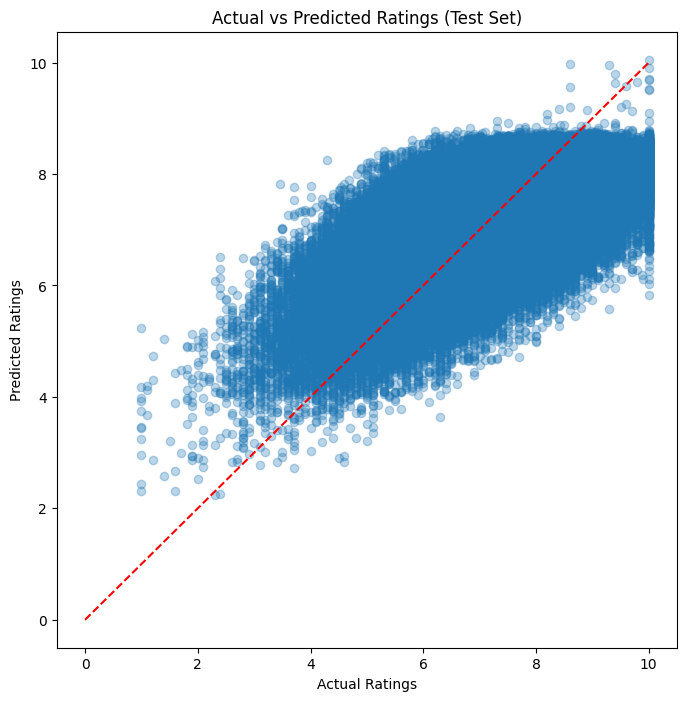

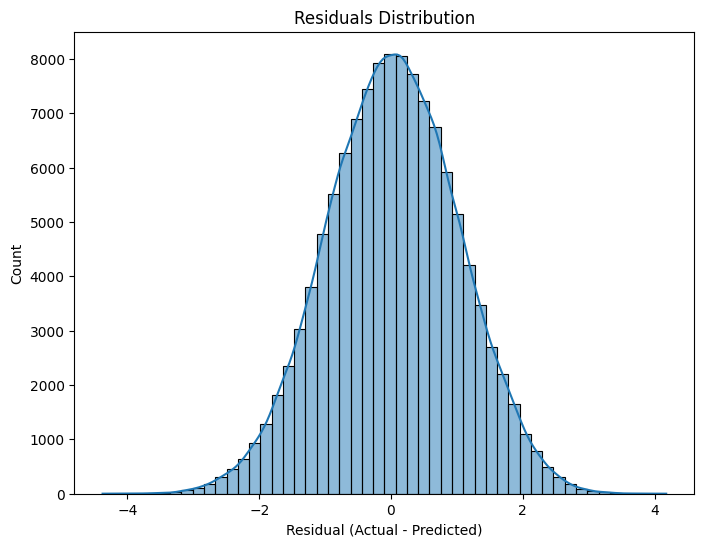

In [46]:
import seaborn as sns
y_true = all_targets.numpy()
y_pred = all_preds.numpy()
residuals = y_true - y_pred

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([0, 10], [0, 10], color='red', linestyle='--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings (Test Set)')
plt.show()

# Residuals plot
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel('Residual (Actual - Predicted)')
plt.title('Residuals Distribution')
plt.show()


In [20]:
from performer_pytorch import SelfAttention
import torch
import torch.nn as nn

class PerformerRecSys(nn.Module):
    def __init__(self, num_users, num_movies, num_numeric, embedding_dim=128,
                 num_heads=4, dropout=0.1, seq_len=10, text_embedding_dim=384, mf_embedding_dim=32):
        super().__init__()

        # embeddings
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.position_embedding = nn.Embedding(seq_len, embedding_dim)

        # performer attention layer
        self.performer = SelfAttention(
            dim=embedding_dim,
            heads=num_heads,
            causal=False,
            dropout=dropout
        )

        # matrix factorization embeddings
        self.mf_user_embedding = nn.Embedding(num_users, mf_embedding_dim)
        self.mf_movie_embedding = nn.Embedding(num_movies, mf_embedding_dim)

        # numeric + text feature projection
        self.numeric_fc = nn.Linear(num_numeric, embedding_dim)
        self.text_fc = nn.Linear(text_embedding_dim, embedding_dim)

        # output head
        total_input_dim = embedding_dim * 4 + 1  # user + movie + pooled history + numeric/text + mf_interaction
        self.output_fc = nn.Sequential(
    nn.Linear(total_input_dim, 256),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(256, 1)
)

    def forward(self, user_ids, movie_ids, watch_history_ids, numeric_feats, text_embeds, return_latent=False):
        user_emb = self.user_embedding(user_ids)
        movie_emb = self.movie_embedding(movie_ids)
        history_emb = self.movie_embedding(watch_history_ids)

        batch_size, seq_len, embed_dim = history_emb.shape
        pos_ids = torch.arange(seq_len, device=watch_history_ids.device).unsqueeze(0).expand(batch_size, seq_len)
        pos_emb = self.position_embedding(pos_ids)
        history_with_pos = history_emb + pos_emb

        transformed = self.performer(history_with_pos)
        pooled_history = transformed.mean(dim=1)

        numeric_proj = self.numeric_fc(numeric_feats)
        text_proj = self.text_fc(text_embeds)

        mf_user = self.mf_user_embedding(user_ids)
        mf_movie = self.mf_movie_embedding(movie_ids)
        mf_interaction = (mf_user * mf_movie).mean(dim=1, keepdim=True)

        combined_latent = torch.cat([user_emb, movie_emb, pooled_history, numeric_proj + text_proj, mf_interaction], dim=1)

        if return_latent:
            return combined_latent

        output = self.output_fc(combined_latent).squeeze(1)
        return output

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Prepare aligned dataset ===
aligned_watch_history = torch.zeros((len(X_user), watch_history.shape[1]), dtype=torch.long)
for idx, u_idx in enumerate(X_user):
    aligned_watch_history[idx] = watch_history[u_idx]

dataset = TensorDataset(X_user, X_movie, X_num, X_emb_idx, aligned_watch_history, y_rating)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)

# === Initialize model ===
model = PerformerRecSys(num_users=num_users,
                        num_movies=num_movies,
                        num_numeric=X_num.shape[1],
                        embedding_dim=128,
                        num_heads=4,
                        dropout=0.1,
                        seq_len=watch_history.shape[1],
                        text_embedding_dim=X_emb_matrix.shape[1]).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.SmoothL1Loss()  # robust to outliers

best_val_loss = float('inf')
patience = 5
patience_counter = 0
epochs = 30

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for user, movie, num_feats, emb_idx, watch_hist, rating in train_loader:
        user, movie = user.to(device), movie.to(device)
        num_feats, emb_idx, watch_hist = num_feats.to(device), emb_idx.to(device), watch_hist.to(device)
        rating = rating.to(device)
        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

        optimizer.zero_grad()
        preds = model(user, movie, watch_hist, num_feats, text_embeds)
        loss = loss_fn(preds, rating)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * user.size(0)
    train_loss /= train_size

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for user, movie, num_feats, emb_idx, watch_hist, rating in val_loader:
            user, movie = user.to(device), movie.to(device)
            num_feats, emb_idx, watch_hist = num_feats.to(device), emb_idx.to(device), watch_hist.to(device)
            rating = rating.to(device)
            text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

            preds = model(user, movie, watch_hist, num_feats, text_embeds)
            loss = loss_fn(preds, rating)
            val_loss += loss.item() * user.size(0)
    val_loss /= val_size

    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_performer_model.pt')
        print("Saved new best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

print(f"Training complete! Best val loss: {best_val_loss:.4f}")

Epoch 1: Train Loss 0.4754, Val Loss 0.4368
Saved new best model
Epoch 2: Train Loss 0.4497, Val Loss 0.4304
Saved new best model
Epoch 3: Train Loss 0.4438, Val Loss 0.4319
Epoch 4: Train Loss 0.4350, Val Loss 0.4469
Epoch 5: Train Loss 0.4227, Val Loss 0.4468
Epoch 6: Train Loss 0.4081, Val Loss 0.4591
Epoch 7: Train Loss 0.3911, Val Loss 0.4691
Early stopping triggered
Training complete! Best val loss: 0.4304


In [21]:
import torch
import torch.nn as nn
from torch.optim import AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Align watch history per row ===
aligned_watch_history = torch.zeros((len(X_user), watch_history.shape[1]), dtype=torch.long)
for idx, u_idx in enumerate(X_user):
    aligned_watch_history[idx] = watch_history[u_idx]

# === Prepare dataset ===
dataset = TensorDataset(X_user, X_movie, X_num, X_emb_idx, aligned_watch_history, y_rating)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)

# === Initialize model ===
model = PerformerRecSys(
    num_users=num_users,
    num_movies=num_movies,
    num_numeric=X_num.shape[1],
    embedding_dim=64,
    num_heads=4,
    dropout=0.4,  # increased dropout
    seq_len=watch_history.shape[1],
    text_embedding_dim=X_emb_matrix.shape[1],
    mf_embedding_dim=32
).to(device)

optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = nn.SmoothL1Loss()  # robust to outliers (can swap for Huber)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

best_val_loss = float('inf')
patience = 6
patience_counter = 0
epochs = 30

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for user, movie, num_feats, emb_idx, watch_hist, rating in train_loader:
        user, movie = user.to(device), movie.to(device)
        num_feats, emb_idx, watch_hist = num_feats.to(device), emb_idx.to(device), watch_hist.to(device)
        rating = rating.to(device)

        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

        optimizer.zero_grad()
        preds = model(user, movie, watch_hist, num_feats, text_embeds)
        loss = loss_fn(preds, rating)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * user.size(0)
    train_loss /= train_size

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for user, movie, num_feats, emb_idx, watch_hist, rating in val_loader:
            user, movie = user.to(device), movie.to(device)
            num_feats, emb_idx, watch_hist = num_feats.to(device), emb_idx.to(device), watch_hist.to(device)
            rating = rating.to(device)

            text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

            preds = model(user, movie, watch_hist, num_feats, text_embeds)
            loss = loss_fn(preds, rating)
            val_loss += loss.item() * user.size(0)
    val_loss /= val_size

    scheduler.step(val_loss)

    print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_performer_mf_regularized.pt')
        print("Saved new best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹ Early stopping triggered")
            break

print(f"Training complete! Best val loss: {best_val_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss 0.5390, Val Loss 0.4368
Saved new best model
Epoch 2: Train Loss 0.4863, Val Loss 0.4278
Saved new best model
Epoch 3: Train Loss 0.4706, Val Loss 0.4267
Saved new best model
Epoch 4: Train Loss 0.4579, Val Loss 0.4455
Epoch 5: Train Loss 0.4444, Val Loss 0.4395
Epoch 6: Train Loss 0.4296, Val Loss 0.4442
Epoch 7: Train Loss 0.4137, Val Loss 0.4530
Epoch 8: Train Loss 0.3929, Val Loss 0.4616
Epoch 9: Train Loss 0.3843, Val Loss 0.4671
⏹ Early stopping triggered
Training complete! Best val loss: 0.4267


In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Align watch history per row ===
aligned_watch_history = torch.zeros((len(X_user), watch_history.shape[1]), dtype=torch.long)
for idx, u_idx in enumerate(X_user):
    aligned_watch_history[idx] = watch_history[u_idx]
dataset = TensorDataset(X_user, X_movie, X_num, X_emb_idx, aligned_watch_history, y_rating)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)

# === Initialize model ===
model = PerformerRecSys(
    num_users=num_users,
    num_movies=num_movies,
    num_numeric=X_num.shape[1],
    embedding_dim=64,
    num_heads=4,
    dropout=0.4,  # increased dropout
    seq_len=watch_history.shape[1],
    text_embedding_dim=X_emb_matrix.shape[1],
    mf_embedding_dim=32
).to(device)

model.load_state_dict(torch.load('best_performer_mf_regularized.pt'))
model.eval()

all_preds = []
all_truths = []

with torch.no_grad():
    for user, movie, num_feats, emb_idx, watch_hist, rating in test_loader:
        user, movie = user.to(device), movie.to(device)
        num_feats, emb_idx, watch_hist = num_feats.to(device), emb_idx.to(device), watch_hist.to(device)
        rating = rating.to(device)

        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)
        preds = model(user, movie, watch_hist, num_feats, text_embeds)

        all_preds.append(preds.cpu())
        all_truths.append(rating.cpu())

all_preds = torch.cat(all_preds).numpy()
all_truths = torch.cat(all_truths).numpy()

mse = mean_squared_error(all_truths, all_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_truths, all_preds)
r2 = r2_score(all_truths, all_preds)

print(f"Final Test MSE: {mse:.4f}")
print(f"Final Test RMSE: {rmse:.4f}")
print(f"Final Test MAE: {mae:.4f}")
print(f"Final Test R²: {r2:.4f}")

Final Test MSE: 0.9981
Final Test RMSE: 0.9991
Final Test MAE: 0.7997
Final Test R²: 0.4250


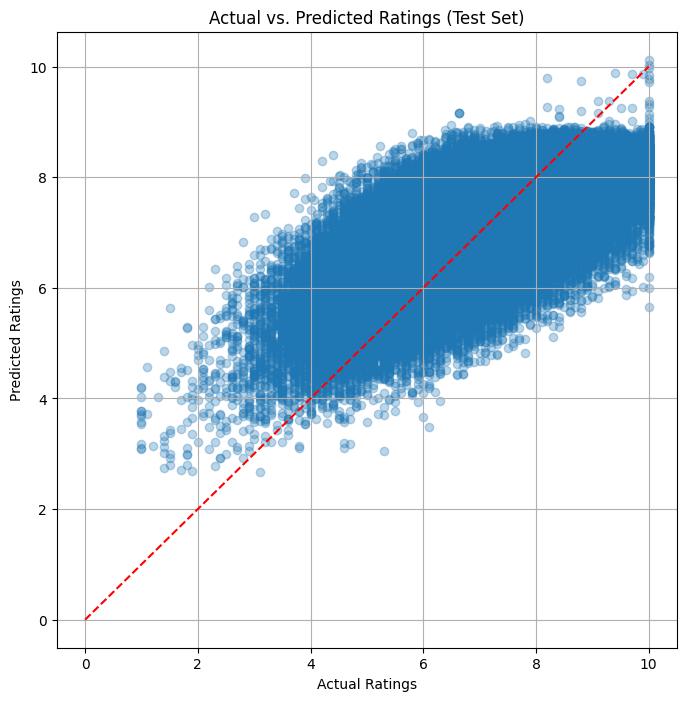

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(all_truths, all_preds, alpha=0.3)
plt.plot([0, 10], [0, 10], color='red', linestyle='--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings (Test Set)')
plt.grid(True)
plt.show()

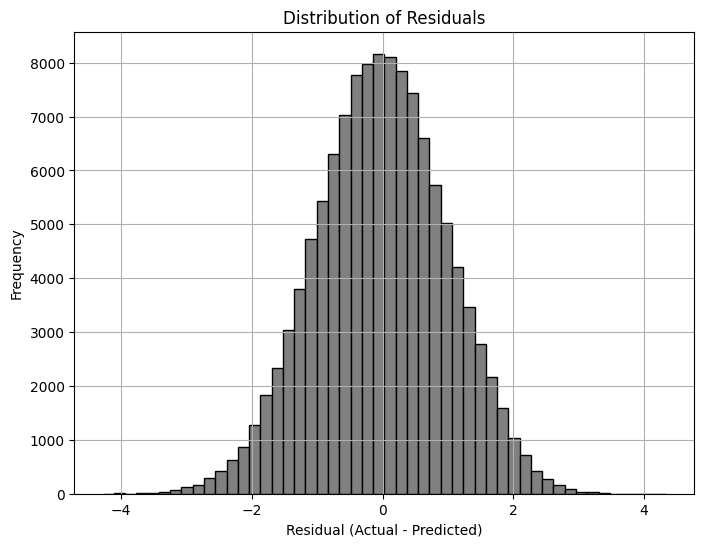

In [24]:
residuals = all_truths - all_preds

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, color='gray', edgecolor='black')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

In [25]:
import torch
import pandas as pd

model.load_state_dict(torch.load('best_performer_mf_regularized.pt'))
model.eval()

all_latents = []
all_preds = []
all_true = []

with torch.no_grad():
    for user, movie, num_feats, emb_idx, watch_hist, rating in test_loader:
        user, movie = user.to(device), movie.to(device)
        num_feats, emb_idx, watch_hist = num_feats.to(device), emb_idx.to(device), watch_hist.to(device)
        rating = rating.cpu().numpy()
        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

        # get latent vectors
        latent_vecs = model(user, movie, watch_hist, num_feats, text_embeds, return_latent=True).cpu().numpy()
        preds = model(user, movie, watch_hist, num_feats, text_embeds).cpu().numpy()

        all_latents.append(latent_vecs)
        all_preds.append(preds)
        all_true.append(rating)

# combine
latents = np.vstack(all_latents)
preds = np.hstack(all_preds)
true_ratings = np.hstack(all_true)

# build dataframe
latent_df = pd.DataFrame(latents, columns=[f'latent_{i}' for i in range(latents.shape[1])])
latent_df['predicted_rating'] = preds
latent_df['true_rating'] = true_ratings

# optionally add numeric features
numeric_cols = [f'numfeat_{i}' for i in range(X_num.shape[1])]
numeric_features = X_num[test_dataset.indices].cpu().numpy()
numeric_df = pd.DataFrame(numeric_features, columns=numeric_cols)

# merge
final_df = pd.concat([latent_df, numeric_df.reset_index(drop=True)], axis=1)
final_df.to_csv('exported_latent_features.csv', index=False)
print("Exported latent features + predictions to exported_latent_features.csv")

Exported latent features + predictions to exported_latent_features.csv


XGBoost Test MSE: 1.0050, RMSE: 1.0025, MAE: 0.8015, R²: 0.4196


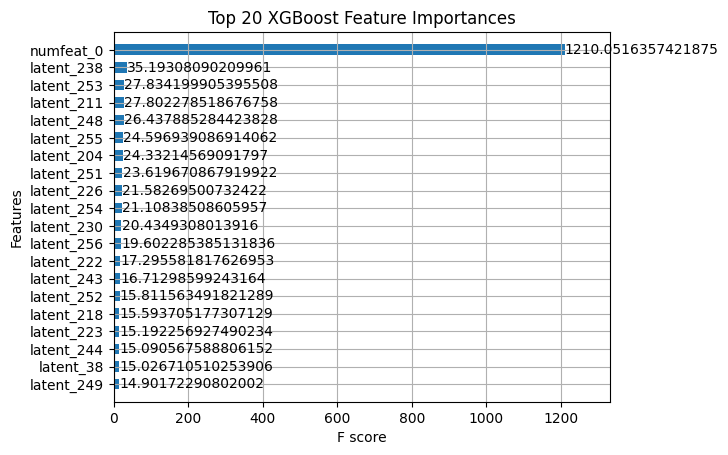

In [26]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# load data
data = pd.read_csv('exported_latent_features.csv')
X = data.drop(columns=['true_rating', 'predicted_rating'])
y = data['true_rating']

# train-test split (or use cross-validation)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train XGBoost
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.05)
model_xgb.fit(X_train, y_train)

# predict + evaluate
y_pred = model_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Test MSE: {mse:.4f}, RMSE: {mse**0.5:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# feature importance plot
xgb.plot_importance(model_xgb, max_num_features=20, importance_type='gain', height=0.6)
plt.title("Top 20 XGBoost Feature Importances")
plt.show()

In [28]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Prepare test features ===
# Get latent representations from the Transformer model
model.eval()
transformer_preds = []
test_latents = []

with torch.no_grad():
    for user, movie, num_feats, emb_idx, watch_hist, rating in test_loader:
        user, movie = user.to(device), movie.to(device)
        num_feats, emb_idx, watch_hist = num_feats.to(device), emb_idx.to(device), watch_hist.to(device)
        text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

        latent = model(user, movie, watch_hist, num_feats, text_embeds, return_latent=True)
        preds = model(user, movie, watch_hist, num_feats, text_embeds)

        transformer_preds.extend(preds.cpu().numpy())
        test_latents.append(latent.cpu().numpy())

transformer_preds = np.array(transformer_preds)
test_latents = np.concatenate(test_latents, axis=0)

numeric_cols = [f'numfeat_{i}' for i in range(X_num.shape[1])]
numeric_features = X_num[test_dataset.indices].cpu().numpy()

full_test_features = np.concatenate([test_latents, numeric_features], axis=1)
full_test_labels = y_rating[test_dataset.indices].cpu().numpy()

dtest = xgb.DMatrix(full_test_features, label=full_test_labels)
xgb_preds = model_xgb.predict(full_test_features)

alpha = 0.7  # weight for transformer, 1 - alpha for XGBoost
ensemble_preds = alpha * transformer_preds + (1 - alpha) * xgb_preds

# === Evaluate ensemble ===
mse = mean_squared_error(full_test_labels, ensemble_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(full_test_labels, ensemble_preds)
r2 = r2_score(full_test_labels, ensemble_preds)

print(f"Ensemble MSE: {mse:.4f}")
print(f"Ensemble RMSE: {rmse:.4f}")
print(f"Ensemble MAE: {mae:.4f}")
print(f"Ensemble R²: {r2:.4f}")

Ensemble MSE: 0.9737
Ensemble RMSE: 0.9867
Ensemble MAE: 0.7900
Ensemble R²: 0.4391


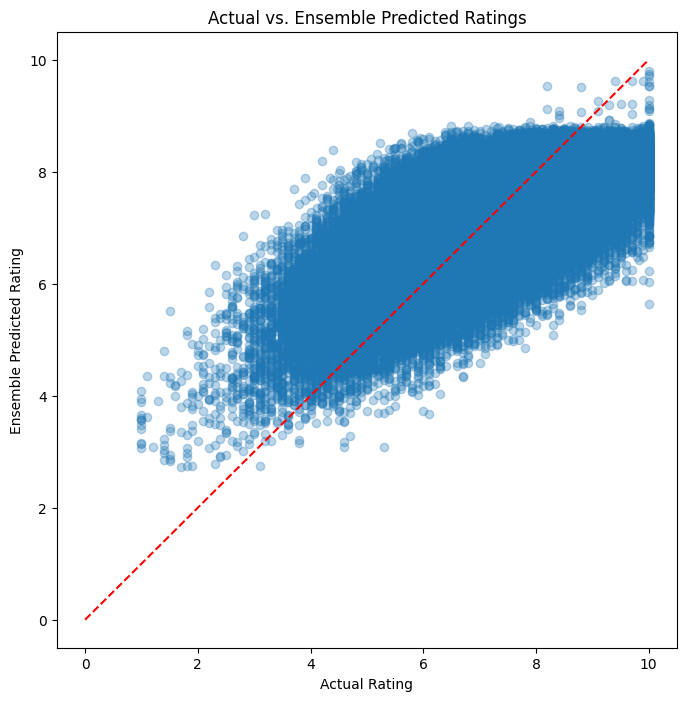

In [29]:
plt.figure(figsize=(8, 8))
plt.scatter(full_test_labels, ensemble_preds, alpha=0.3)
plt.plot([0, 10], [0, 10], color='red', linestyle='--')  # ideal line
plt.xlabel('Actual Rating')
plt.ylabel('Ensemble Predicted Rating')
plt.title('Actual vs. Ensemble Predicted Ratings')
plt.show()

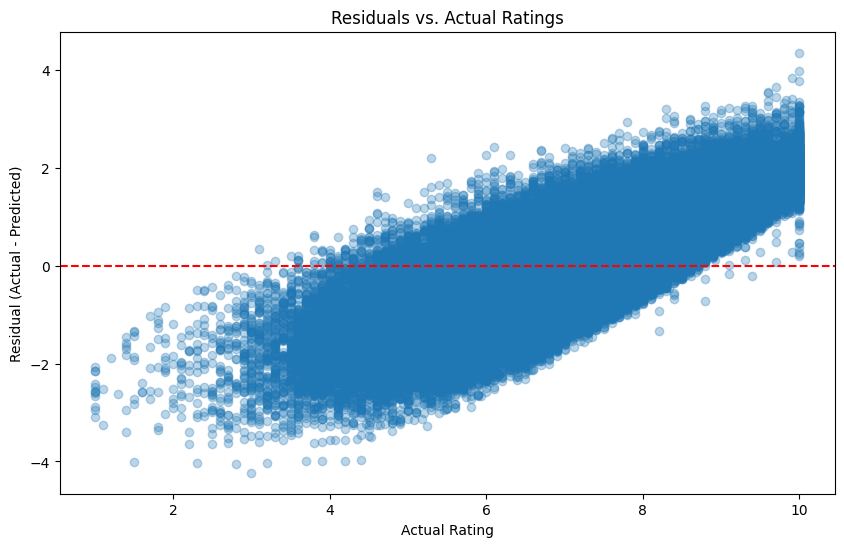

In [30]:
residuals = full_test_labels - ensemble_preds

plt.figure(figsize=(10, 6))
plt.scatter(full_test_labels, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Rating')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs. Actual Ratings')
plt.show()

In [25]:
torch.save(model.state_dict(), 'transformer_performer_mf.pt')
print("Saved Transformer + Performer + MF model!")

Saved Transformer + Performer + MF model!


In [26]:
import joblib
joblib.dump(model_xgb, 'xgboost_meta_model.pkl')
print("Saved XGBoost model!")

Saved XGBoost model!


In [8]:
import joblib
model_xgb = joblib.load('xgboost_meta_model.pkl')
print("Loaded XGBoost model")

Loaded XGBoost model


In [31]:
import numpy as np
import pandas as pd

# === Combine transformer + xgboost + latent + numeric ===

#  Transformer predictions
transformer_preds = np.array(transformer_preds).reshape(-1, 1)  # shape (N, 1)

# XGBoost predictions
xgb_preds = np.array(xgb_preds).reshape(-1, 1)  # shape (N, 1)

#  Transformer latent vectors
latent_features = test_latents  # shape (N, latent_dim)

#  Numeric features
numeric_features = X_num[test_dataset.indices].cpu().numpy()  # shape (N, num_numeric)

#  True labels
labels = y_rating[test_dataset.indices].cpu().numpy()

# === Stack into meta-feature matrix ===
meta_features = np.concatenate([transformer_preds, xgb_preds, latent_features, numeric_features], axis=1)

# Save into a DataFrame for easier inspection
meta_df = pd.DataFrame(meta_features, columns=[
    'transformer_pred', 'xgb_pred'
] + [f'latent_{i}' for i in range(latent_features.shape[1])] + [f'numfeat_{i}' for i in range(numeric_features.shape[1])])

meta_df['label'] = labels

print(f"Prepared meta-learner dataset with shape: {meta_df.shape}")

Prepared meta-learner dataset with shape: (120086, 265)


In [36]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# === Prepare features and labels ===
X_meta = meta_df.drop(columns=['label']).values
y_meta = meta_df['label'].values

# === Split into train/val ===
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(
    X_meta, y_meta, test_size=0.2, random_state=42
)

# === Train XGBoost meta-learner ===
meta_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

meta_model.fit(X_train_meta, y_train_meta)

# === Predict on validation ===
meta_val_preds = meta_model.predict(X_val_meta)

# === Evaluate ===
mse = mean_squared_error(y_val_meta, meta_val_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_meta, meta_val_preds)
r2 = r2_score(y_val_meta, meta_val_preds)

print(f"Meta-learner MSE: {mse:.4f}")
print(f"Meta-learner RMSE: {rmse:.4f}")
print(f"Meta-learner MAE: {mae:.4f}")
print(f"Meta-learner R²: {r2:.4f}")

Meta-learner MSE: 1.0414
Meta-learner RMSE: 1.0205
Meta-learner MAE: 0.8144
Meta-learner R²: 0.3986


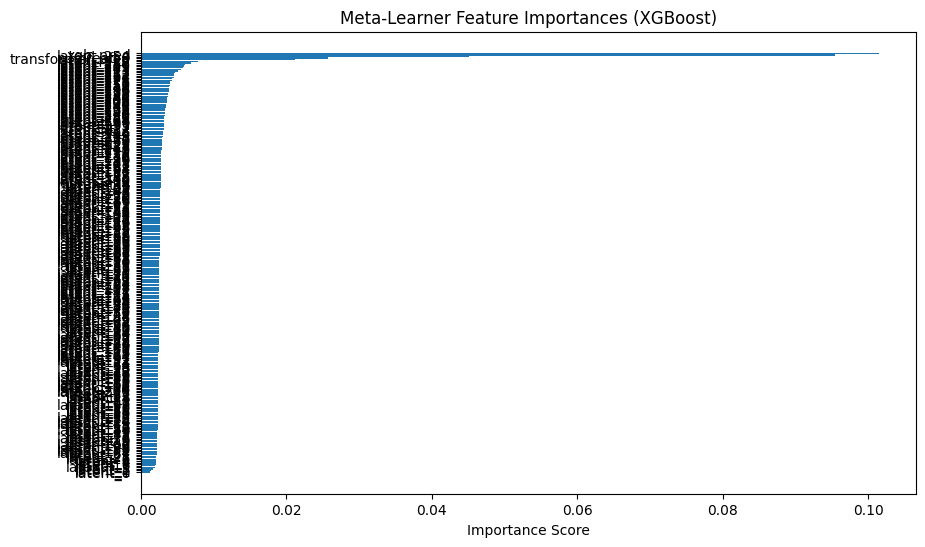

In [37]:
importances = meta_model.feature_importances_
feature_names = meta_df.drop(columns=['label']).columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance Score')
plt.title('Meta-Learner Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.show()

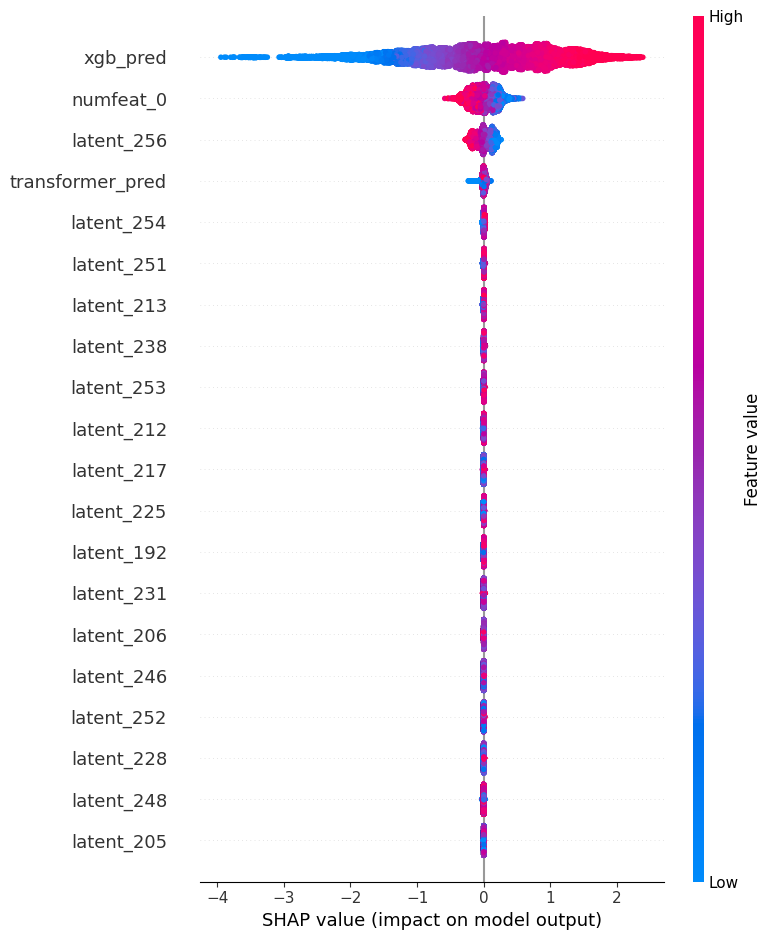

In [39]:
import shap

# Create TreeExplainer for XGBoost
explainer = shap.Explainer(meta_model)
shap_values = explainer(X_val_meta)

# Summary plot: shows global feature importance + effect
shap.summary_plot(shap_values, X_val_meta, feature_names=meta_df.drop(columns=['label']).columns)


In [40]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Assemble meta features ===
selected_features = np.concatenate([
    transformer_preds.reshape(-1, 1),     # shape (N, 1)
    test_latents,                         # shape (N, latent_dim)
    numeric_features[:, [0]],             # top numeric feature only
    xgb_preds.reshape(-1, 1)              # XGBoost predictions
], axis=1)

# Split into train/val (80-20)
from sklearn.model_selection import train_test_split
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(
    selected_features, full_test_labels, test_size=0.2, random_state=42
)

# === Train XGBoost meta-learner ===
meta_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=1
)

meta_model.fit(
    X_train_meta, y_train_meta,
    eval_set=[(X_val_meta, y_val_meta)],
    verbose=True
)

# === Evaluate meta-learner ===
meta_preds = meta_model.predict(X_val_meta)

mse = mean_squared_error(y_val_meta, meta_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_meta, meta_preds)
r2 = r2_score(y_val_meta, meta_preds)

print(f"Refined Meta-Learner MSE: {mse:.4f}")
print(f"Refined Meta-Learner RMSE: {rmse:.4f}")
print(f"Refined Meta-Learner MAE: {mae:.4f}")
print(f"Refined Meta-Learner R²: {r2:.4f}")

[0]	validation_0-rmse:1.28754
[1]	validation_0-rmse:1.26148
[2]	validation_0-rmse:1.23761
[3]	validation_0-rmse:1.21567
[4]	validation_0-rmse:1.19649
[5]	validation_0-rmse:1.17809
[6]	validation_0-rmse:1.16126
[7]	validation_0-rmse:1.14601
[8]	validation_0-rmse:1.13203
[9]	validation_0-rmse:1.11926
[10]	validation_0-rmse:1.10780
[11]	validation_0-rmse:1.09734
[12]	validation_0-rmse:1.08798
[13]	validation_0-rmse:1.07959
[14]	validation_0-rmse:1.07228
[15]	validation_0-rmse:1.06521
[16]	validation_0-rmse:1.05889
[17]	validation_0-rmse:1.05348
[18]	validation_0-rmse:1.04862
[19]	validation_0-rmse:1.04414
[20]	validation_0-rmse:1.03992
[21]	validation_0-rmse:1.03621
[22]	validation_0-rmse:1.03292
[23]	validation_0-rmse:1.02974
[24]	validation_0-rmse:1.02706
[25]	validation_0-rmse:1.02449
[26]	validation_0-rmse:1.02233
[27]	validation_0-rmse:1.02025
[28]	validation_0-rmse:1.01840
[29]	validation_0-rmse:1.01672
[30]	validation_0-rmse:1.01522
[31]	validation_0-rmse:1.01394
[32]	validation_0-

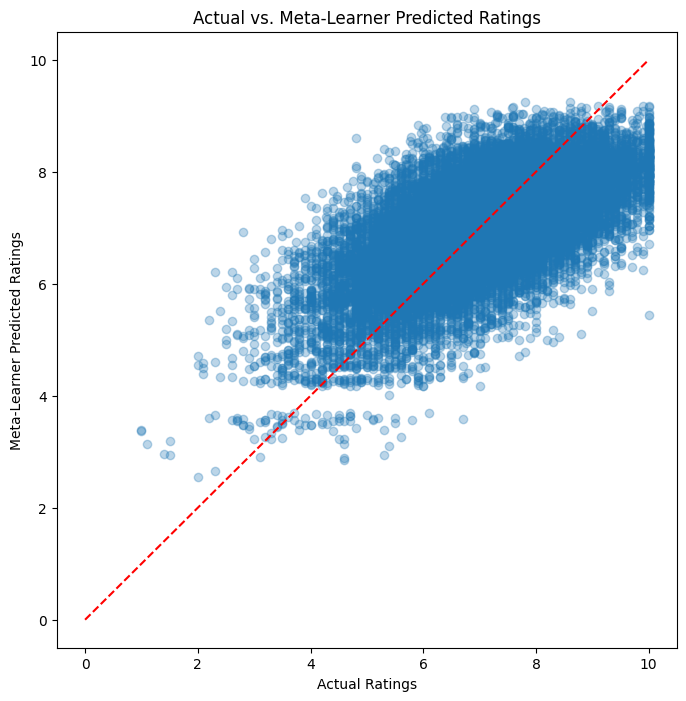

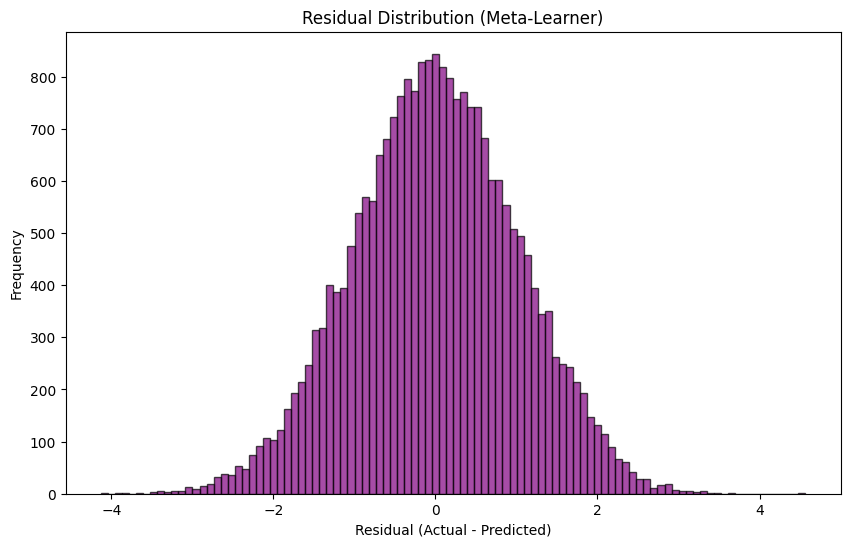

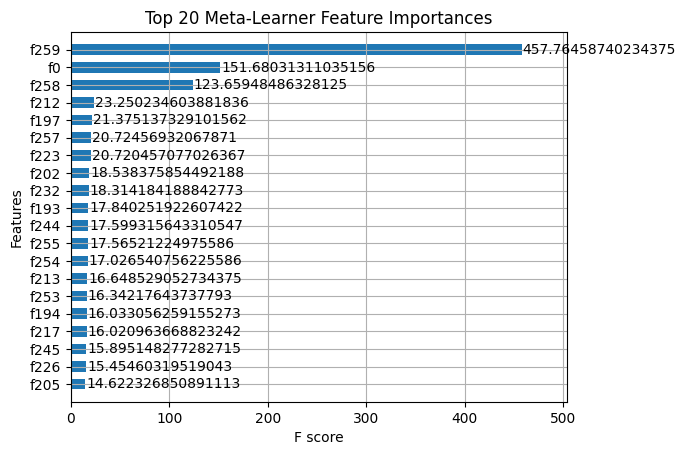

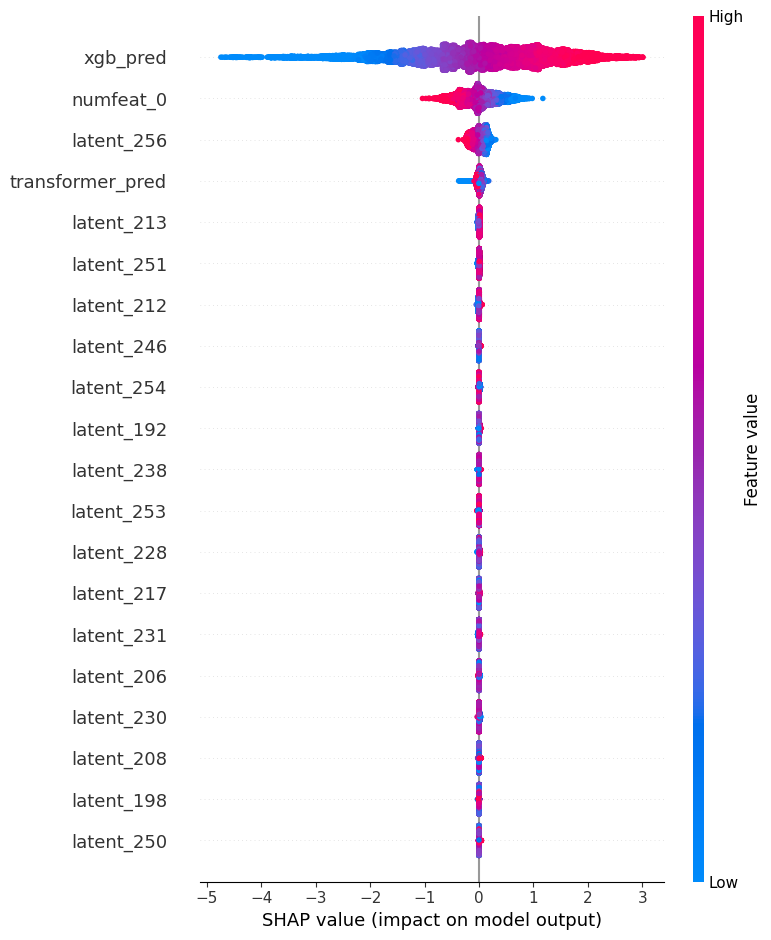

In [41]:
plt.figure(figsize=(8, 8))
plt.scatter(y_val_meta, meta_preds, alpha=0.3)
plt.plot([0, 10], [0, 10], color='red', linestyle='--')
plt.xlabel('Actual Ratings')
plt.ylabel('Meta-Learner Predicted Ratings')
plt.title('Actual vs. Meta-Learner Predicted Ratings')
plt.show()

# === Residuals Plot ===
residuals = y_val_meta - meta_preds
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=100, color='purple', edgecolor='black', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residual Distribution (Meta-Learner)')
plt.show()

# === Feature Importances ===
xgb.plot_importance(meta_model, max_num_features=20, importance_type='gain', height=0.6)
plt.title('Top 20 Meta-Learner Feature Importances')
plt.show()

# === SHAP Analysis ===
explainer = shap.Explainer(meta_model)
shap_values = explainer(X_val_meta)

shap.summary_plot(shap_values, X_val_meta, feature_names=[
    'transformer_pred'
] + [f'latent_{i}' for i in range(test_latents.shape[1])] + ['numfeat_0', 'xgb_pred'])

In [42]:
def compute_top_n_hit_rate(preds, labels, N=10):
    hits = 0
    total = 0
    for user_idx in np.unique(X_user[test_dataset.indices].cpu().numpy()):
        user_mask = X_user[test_dataset.indices].cpu().numpy() == user_idx
        user_preds = preds[user_mask]
        user_labels = labels[user_mask]

        top_n_idx = np.argsort(user_preds)[-N:]
        top_n_labels = user_labels[top_n_idx]

        hits += np.sum(top_n_labels >= 4)  # assume rating ≥4 is relevant
        total += N

    hit_rate = hits / total
    print(f"Top-{N} Hit Rate: {hit_rate:.4f}")

compute_top_n_hit_rate(ensemble_preds, full_test_labels, N=10)

Top-10 Hit Rate: 0.8730


Exported recommendations to user_recommendations_sample.csv

User 122 → Top 10 Movies:
  1. Movie ID 22819 → Score 8.9772
  2. Movie ID 17578 → Score 8.9158
  3. Movie ID 17895 → Score 8.9006
  4. Movie ID 17774 → Score 8.8896
  5. Movie ID 22584 → Score 8.8751
  6. Movie ID 19597 → Score 8.8441
  7. Movie ID 24664 → Score 8.8389
  8. Movie ID 20455 → Score 8.8270
  9. Movie ID 17744 → Score 8.8252
  10. Movie ID 16269 → Score 8.8249

User 3201 → Top 10 Movies:
  1. Movie ID 17895 → Score 8.9074
  2. Movie ID 17578 → Score 8.8809
  3. Movie ID 22819 → Score 8.8763
  4. Movie ID 24070 → Score 8.8656
  5. Movie ID 24005 → Score 8.8633
  6. Movie ID 21352 → Score 8.8630
  7. Movie ID 17744 → Score 8.8595
  8. Movie ID 16269 → Score 8.8447
  9. Movie ID 19759 → Score 8.8440
  10. Movie ID 19178 → Score 8.8420

User 8376 → Top 10 Movies:
  1. Movie ID 22819 → Score 8.8716
  2. Movie ID 17744 → Score 8.8072
  3. Movie ID 24070 → Score 8.7840
  4. Movie ID 17895 → Score 8.7821
  5. Movie ID 1

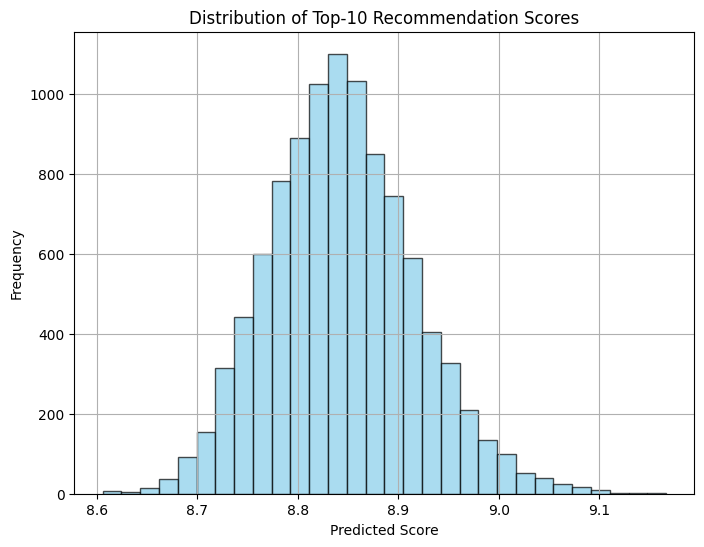

Saved plot: recommendation_score_distribution.png


In [45]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Load data and model ===
data = torch.load('final_training_data_with_watch.pt')
model = PerformerRecSys(
    num_users=data['num_users'],
    num_movies=data['num_movies'],
    num_numeric=data['X_num'].shape[1],
    embedding_dim=64,  # <-- MUST match saved checkpoint
    num_heads=4,
    dropout=0.1,
    seq_len=data['watch_history'].shape[1],
    text_embedding_dim=data['X_emb_matrix'].shape[1],
    mf_embedding_dim=32
).to(device)
model.load_state_dict(torch.load('best_performer_mf_regularized.pt'))
model.eval()

# === Setup ===
user2idx = data['user2idx']
idx2user = {v: k for k, v in user2idx.items()}
num_users = data['num_users']
num_movies = data['num_movies']
X_emb_matrix = data['X_emb_matrix'].to(device)

# Randomly select ~1000 users
sampled_user_indices = random.sample(range(num_users), 1000)

top_k = 10
recommendations = []

for user_idx in sampled_user_indices:
    user_tensor = torch.tensor([user_idx] * num_movies).to(device)
    movie_tensor = torch.arange(num_movies).to(device)
    num_feats = data['X_num'][:num_movies].to(device)
    emb_idx = torch.arange(num_movies).to(device)
    watch_hist = data['watch_history'][user_idx].unsqueeze(0).expand(num_movies, -1).to(device)
    text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

    with torch.no_grad():
        preds = model(user_tensor, movie_tensor, watch_hist, num_feats, text_embeds).cpu().numpy()

    top_indices = preds.argsort()[-top_k:][::-1]
    top_movie_ids = [list(data['movie2idx'].keys())[list(data['movie2idx'].values()).index(idx)] for idx in [emb_idx[i].item() for i in top_indices]]
    recommendations.append({
        'user_id': idx2user[user_idx],
        'top_movies': top_movie_ids,
        'top_scores': preds[top_indices].tolist()
    })

# === Export to CSV ===
recommendation_df = pd.DataFrame(recommendations)
recommendation_df.to_csv('user_recommendations_sample.csv', index=False)
print("Exported recommendations to user_recommendations_sample.csv")

# === Show recommendations for 5 random users ===
for entry in random.sample(recommendations, 5):
    print(f"\nUser {entry['user_id']} → Top {top_k} Movies:")
    for i, (movie, score) in enumerate(zip(entry['top_movies'], entry['top_scores'])):
        print(f"  {i+1}. Movie ID {movie} → Score {score:.4f}")

# === Plot score distribution ===
all_scores = np.concatenate([entry['top_scores'] for entry in recommendations])
plt.figure(figsize=(8, 6))
plt.hist(all_scores, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title(f'Distribution of Top-{top_k} Recommendation Scores')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('recommendation_score_distribution.png')
plt.show()
print("Saved plot: recommendation_score_distribution.png")

In [50]:
df = pd.read_csv('combined_training_data.csv', low_memory=False)
df['movie_id'] = df['movie_id'].astype(str)

# Keep only unique movie_id → title mappings
movie_meta = df[['movie_id', 'title', 'genres']].drop_duplicates(subset='movie_id').set_index('movie_id')

# Convert to dict for fast lookup
movie_map = movie_meta.to_dict('index')

# Sample top-10 movie IDs
sample_recs = [22819, 17578, 17895, 17774, 22584, 19597, 24664, 20455, 17744, 16269]

print("\n🎬 Top-10 Recommendation Titles:\n")
for rank, movie_id in enumerate(sample_recs, 1):
    meta = movie_map.get(movie_id, {'title': 'Unknown', 'genres': 'Unknown'})
    print(f"Rank {rank}: Movie ID {movie_id} → {meta['title']} | Genres: {meta['genres']}")


🎬 Top-10 Recommendation Titles:

Rank 1: Movie ID 22819 → Unknown | Genres: Unknown
Rank 2: Movie ID 17578 → Unknown | Genres: Unknown
Rank 3: Movie ID 17895 → Unknown | Genres: Unknown
Rank 4: Movie ID 17774 → Unknown | Genres: Unknown
Rank 5: Movie ID 22584 → Unknown | Genres: Unknown
Rank 6: Movie ID 19597 → Unknown | Genres: Unknown
Rank 7: Movie ID 24664 → Unknown | Genres: Unknown
Rank 8: Movie ID 20455 → Unknown | Genres: Unknown
Rank 9: Movie ID 17744 → Unknown | Genres: Unknown
Rank 10: Movie ID 16269 → Unknown | Genres: Unknown


In [51]:
missing_ids = [mid for mid in sample_recs if mid not in df['movie_id'].values]
print(f"Missing movie IDs: {missing_ids}")

Missing movie IDs: [22819, 17578, 17895, 17774, 22584, 19597, 24664, 20455, 17744, 16269]


In [52]:
data = torch.load('final_training_data_with_watch.pt')

# Extract mappings
movie2idx = data['movie2idx']
idx2movie = {v: k for k, v in movie2idx.items()}

print(f"Loaded {len(movie2idx)} unique movies.")

# Check if top recommended IDs are present
top_movie_ids = [22819, 17578, 17895, 17774, 22584, 19597, 24664, 20455, 17744, 16269]
missing = [mid for mid in top_movie_ids if mid not in movie2idx]

if missing:
    print(f"⚠ Missing movie IDs in movie2idx: {missing}")
else:
    print("All top recommended IDs are present!")


✅ Loaded 26189 unique movies.
⚠ Missing movie IDs in movie2idx: [22819, 17578, 17895, 17774, 22584, 19597, 24664, 20455, 17744, 16269]
📦 Exported full_movie_id_list.csv


In [54]:
combined_df = pd.read_csv('combined_training_data.csv', low_memory=False)
movieid_to_tmdbid = combined_df[['movie_id', 'tmdb_id_x']].drop_duplicates().set_index('movie_id')['tmdb_id_x'].to_dict()

In [56]:
tmdb_df = pd.read_csv('TMDB_movie_dataset_v11-2.csv', low_memory=False)

# Drop duplicate TMDb IDs, keeping first
tmdb_df_unique = tmdb_df.drop_duplicates(subset='id', keep='first')

# Now build mapping safely
tmdbid_to_meta = tmdb_df_unique.set_index('id').to_dict('index')

print(f"Loaded {len(tmdbid_to_meta)} unique TMDb mappings")

Loaded 1228539 unique TMDb mappings


In [57]:
tmdb_id = movieid_to_tmdbid.get(movie_id, 'Unknown')
meta = tmdbid_to_meta.get(tmdb_id, {'title': 'Unknown', 'genres': 'Unknown'})
print(f"Movie ID {movie_id} → TMDB ID {tmdb_id} → Title: {meta['title']} | Genres: {meta['genres']}")

Movie ID 16269 → TMDB ID Unknown → Title: Unknown | Genres: Unknown


In [58]:
if movie_id in movieid_to_tmdbid:
    print(f"Found TMDB ID: {movieid_to_tmdbid[movie_id]}")
else:
    print(f"⚠ovie ID {movie_id} missing in movieid_to_tmdbid mapping")

⚠ Movie ID 16269 missing in movieid_to_tmdbid mapping


In [59]:
import pandas as pd

# Load TMDb metadata
tmdb_df = pd.read_csv('TMDB_movie_dataset_v11-2.csv', low_memory=False)

# Ensure unique mapping
tmdb_df = tmdb_df.drop_duplicates(subset='id')
tmdbid_to_meta = tmdb_df.set_index('id').to_dict('index')

# Example: process top recommended movie IDs
recommended_movie_ids = [16269, 17578, 17895, 22819, 24070]  # example list

for movie_id in recommended_movie_ids:
    meta = tmdbid_to_meta.get(movie_id, {'title': 'Unknown', 'genres': 'Unknown'})
    title = meta.get('title', 'Unknown')
    genres = meta.get('genres', 'Unknown')
    print(f"Movie ID {movie_id} → Title: {title} | Genres: {genres}")

Movie ID 16269 → Title: God of Gamblers | Genres: Action, Comedy, Drama
Movie ID 17578 → Title: The Adventures of Tintin | Genres: Adventure, Animation, Mystery
Movie ID 17895 → Title: Antarctica | Genres: Drama, Adventure
Movie ID 22819 → Title: American Son | Genres: Drama
Movie ID 24070 → Title: Mixed Nuts | Genres: Comedy, Drama, Romance


In [60]:
import torch
import numpy as np
import pandas as pd
from collections import Counter
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

# Load TMDB metadata (id → title, genres)
tmdb_df = pd.read_csv('TMDB_movie_dataset_v11-2.csv', low_memory=False)
tmdb_map = tmdb_df.drop_duplicates(subset='id').set_index('id')[['title', 'genres']].to_dict('index')

# Randomly pick 100 test users
unique_test_users = list(set(X_user[test_dataset.indices].cpu().numpy()))
sample_users = random.sample(unique_test_users, min(100, len(unique_test_users)))

top_n = 10
user_recs = {}

for user_id in sample_users:
    user_tensor = torch.tensor([user_id] * num_movies).to(device)
    movie_tensor = torch.arange(num_movies).to(device)
    num_feats = X_num[:num_movies].to(device)
    emb_idx = torch.arange(num_movies).to(device)
    watch_hist = watch_history[user_id].unsqueeze(0).repeat(num_movies, 1).to(device)
    text_embeds = X_emb_matrix[emb_idx.cpu()].to(device)

    with torch.no_grad():
        preds = model(user_tensor, movie_tensor, watch_hist, num_feats, text_embeds).cpu().numpy()
    top_indices = preds.argsort()[-top_n:][::-1]
    top_movie_ids = [int(movie_tensor[i].cpu().item()) for i in top_indices]

    user_recs[user_id] = top_movie_ids

# Flatten all top-N movies across users
all_movies = [m for sublist in user_recs.values() for m in sublist]
unique_movies = set(all_movies)
print(f"Total unique movies in top-{top_n} across {len(sample_users)} users: {len(unique_movies)}")

# Most frequently recommended
movie_counts = Counter(all_movies)
print("\nMost frequently recommended movies:")
for movie_id, count in movie_counts.most_common(10):
    tmdb_info = tmdb_map.get(movie_id, {'title': 'Unknown', 'genres': 'Unknown'})
    print(f"Movie ID {movie_id} → {tmdb_info['title']} | {tmdb_info['genres']} → Count: {count}")

# User-to-user overlap
overlap_matrix = pd.DataFrame(index=sample_users, columns=sample_users, dtype=int)
for u1 in sample_users:
    for u2 in sample_users:
        set1, set2 = set(user_recs[u1]), set(user_recs[u2])
        overlap_matrix.loc[u1, u2] = len(set1 & set2)

# Export overlap matrix
overlap_matrix.to_csv('user_overlap_matrix.csv')
print("\n Exported user-to-user overlap matrix to 'user_overlap_matrix.csv'")

# Average overlap
avg_overlap = overlap_matrix.values[np.triu_indices_from(overlap_matrix, k=1)].mean()
print(f"\nAverage overlap between user top-{top_n} lists: {avg_overlap:.2f} movies")

Total unique movies in top-10 across 100 users: 70

Most frequently recommended movies:
Movie ID 5667 → Unknown | Unknown → Count: 99
Movie ID 5623 → The Devil Came from Akasava | Adventure, Thriller → Count: 96
Movie ID 5968 → The Woman in Red | Comedy, Romance → Count: 79
Movie ID 4444 → Unknown | Unknown → Count: 76
Movie ID 4360 → Unknown | Unknown → Count: 63
Movie ID 3912 → Unknown | Unknown → Count: 46
Movie ID 3967 → Blondie's Lucky Day | Comedy → Count: 46
Movie ID 6304 → Meine Tochter darf es nie erfahren | Drama → Count: 41
Movie ID 4320 → Unknown | Unknown → Count: 37
Movie ID 5832 → Vier Meerjungfrauen II - Liebe à la carte | Comedy → Count: 36

 Exported user-to-user overlap matrix to 'user_overlap_matrix.csv'

Average overlap between user top-10 lists: 4.95 movies


In [62]:
torch.save(model.state_dict(), 'best_model_deploy_ready.pt')

In [63]:
import pickle

with open('user2idx.pkl', 'wb') as f:
    pickle.dump(user2idx, f)
with open('movie2idx.pkl', 'wb') as f:
    pickle.dump(movie2idx, f)
with open('idx2movie.pkl', 'wb') as f:
    pickle.dump(idx2movie, f)

In [64]:
np.save('X_emb_matrix.npy', X_emb_matrix.cpu().numpy())